## Problem statement:

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Dictionary:
 - There are two csv files given:-

 - **train_1.csv:**
 -In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

 - The page name contains data in this format:

 - SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN
having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

 - **Exog_Campaign_eng:**
 - This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

 - There’s 1 for dates with campaigns and 0 for remaining dates.

 - It is to be treated as an exogenous variable for models when training and forecasting data for pages in English.

In [84]:
df=pd.read_csv("train_1.csv")

In [85]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [86]:
print("No.of rows: ", df.shape[0])
print("No.of columns: ", df.shape[1])

No.of rows:  145063
No.of columns:  551


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [88]:
Exog_Campaign_eng = pd.read_csv("Exog_Campaign_eng")
Exog_Campaign_eng.shape

(550, 1)

In [89]:
df['Page'].value_counts()

Page
2NE1_zh.wikipedia.org_all-access_spider                                                     1
Rafael_Leónidas_Trujillo_es.wikipedia.org_mobile-web_all-agents                             1
América_Central_es.wikipedia.org_mobile-web_all-agents                                      1
Física_es.wikipedia.org_mobile-web_all-agents                                               1
Inquisición_es.wikipedia.org_mobile-web_all-agents                                          1
                                                                                           ..
The_First_Avenger:_Civil_War_de.wikipedia.org_all-access_spider                             1
The_Fast_and_the_Furious_(Filmreihe)_de.wikipedia.org_all-access_spider                     1
The_Expendables_3_de.wikipedia.org_all-access_spider                                        1
The_Expanse_(Fernsehserie)_de.wikipedia.org_all-access_spider                               1
Francisco_el_matemático_(serie_de_televisión_de_2017)_e

## EDA

The page name contains data in this format:

**SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN**

Let's extract language, access type, access origin and name of each page.

#### Extracting language

In [90]:
import re

In [91]:
# extracting language
def Extract_Language(name):
  if len(re.findall(r'_(.{2}).wikipedia.org_', name)) == 1 :
    return re.findall(r'_(.{2}).wikipedia.org_', name)[0]
  else:
    return 'Unknown'

# Apply the function to extract the language
df['Language'] = df['Page'].map(Extract_Language)

In [92]:
df['Language'].value_counts()

Language
en         24108
ja         20431
de         18547
Unknown    17855
fr         17802
zh         17229
ru         15022
es         14069
Name: count, dtype: int64

In [93]:
# Impute language names using their codes.
languages = {'de':'German',
        'en': 'English',
        'es': 'Spanish',
        'fr': 'French',
        'ja': 'Japenese' ,
        'ru': 'Russian',
        'zh': 'Chinese',
        'Unknown': 'Unknown_Language'}

df['Language']= df['Language'].map(languages)

#### Extracting ACCESS ORIGIN :

In [94]:
df['Access_origin']=df['Page'].str.split('_').str[-1]

In [95]:
df['Access_origin'].value_counts(normalize=True)

Access_origin
all-agents    0.759325
spider        0.240675
Name: proportion, dtype: float64

#### Extracting ACCESS TYPE :

In [96]:
df['Access_type']=df['Page'].str.split('_').str[-2]

In [97]:
df['Access_type'].value_counts(normalize=True)

Access_type
all-access    0.512295
mobile-web    0.247748
desktop       0.239958
Name: proportion, dtype: float64

In [98]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language,Access_origin,Access_type
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,26.0,14.0,20.0,22.0,19.0,18.0,20.0,Chinese,spider,all-access
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,15.0,9.0,30.0,52.0,45.0,26.0,20.0,Chinese,spider,all-access
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,7.0,4.0,4.0,6.0,3.0,4.0,17.0,Chinese,spider,all-access
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,27.0,16.0,11.0,17.0,19.0,10.0,11.0,Chinese,spider,all-access
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.0,3.0,11.0,27.0,13.0,36.0,10.0,Chinese,spider,all-access


- There are some NaN values for some webpages across different dates.

In [99]:
df.duplicated().sum()

0

In [100]:
indexes = df.head(2).columns[1:][range(0,549,10)].values
indexes

array(['2015-07-01', '2015-07-11', '2015-07-21', '2015-07-31',
       '2015-08-10', '2015-08-20', '2015-08-30', '2015-09-09',
       '2015-09-19', '2015-09-29', '2015-10-09', '2015-10-19',
       '2015-10-29', '2015-11-08', '2015-11-18', '2015-11-28',
       '2015-12-08', '2015-12-18', '2015-12-28', '2016-01-07',
       '2016-01-17', '2016-01-27', '2016-02-06', '2016-02-16',
       '2016-02-26', '2016-03-07', '2016-03-17', '2016-03-27',
       '2016-04-06', '2016-04-16', '2016-04-26', '2016-05-06',
       '2016-05-16', '2016-05-26', '2016-06-05', '2016-06-15',
       '2016-06-25', '2016-07-05', '2016-07-15', '2016-07-25',
       '2016-08-04', '2016-08-14', '2016-08-24', '2016-09-03',
       '2016-09-13', '2016-09-23', '2016-10-03', '2016-10-13',
       '2016-10-23', '2016-11-02', '2016-11-12', '2016-11-22',
       '2016-12-02', '2016-12-12', '2016-12-22'], dtype=object)

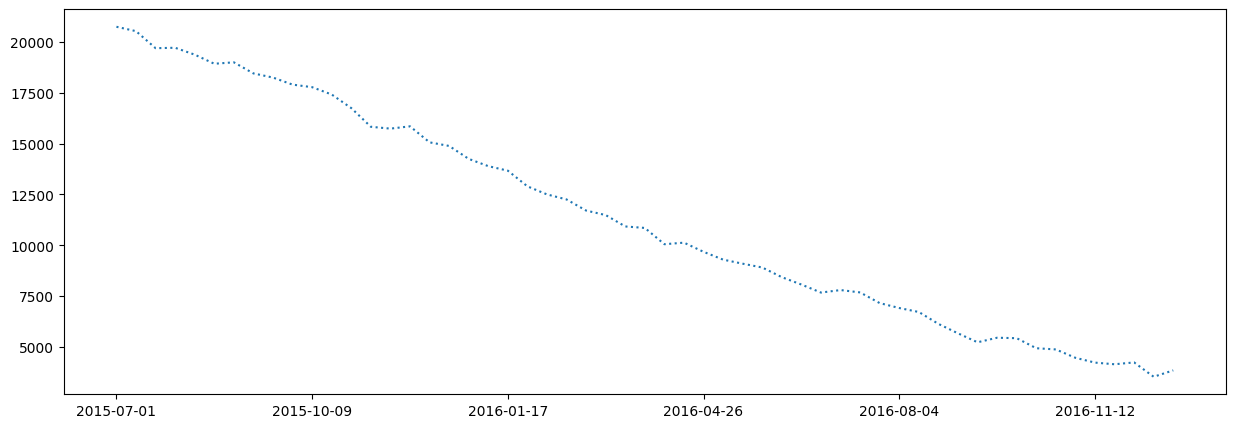

In [101]:
plt.figure(figsize=(15, 5))
df.isna().sum()[indexes].plot(linestyle='dotted')
plt.show()

- From the above plot, it can be observed that null values are decreasing over the time.
- These NaN values might indicate that the webpages have not yet been created on that data.

In [102]:
# Replacing the NaN values with 0
df.fillna(0,inplace=True)

In [103]:
df.isnull().sum().sum()

0

In [104]:
# Creating a copy of the dataframe
data = df.copy()

In [105]:
data

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language,Access_origin,Access_type
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,26.0,14.0,20.0,22.0,19.0,18.0,20.0,Chinese,spider,all-access
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,15.0,9.0,30.0,52.0,45.0,26.0,20.0,Chinese,spider,all-access
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,7.0,4.0,4.0,6.0,3.0,4.0,17.0,Chinese,spider,all-access
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,27.0,16.0,11.0,17.0,19.0,10.0,11.0,Chinese,spider,all-access
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,3.0,11.0,27.0,13.0,36.0,10.0,Chinese,spider,all-access
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,13.0,12.0,13.0,3.0,5.0,10.0,Spanish,spider,all-access
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spanish,spider,all-access
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spanish,spider,all-access
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spanish,spider,all-access


In [106]:
data.groupby('Language')['Page'].count()

Language
Chinese             17229
English             24108
French              17802
German              18547
Japenese            20431
Russian             15022
Spanish             14069
Unknown_Language    17855
Name: Page, dtype: int64

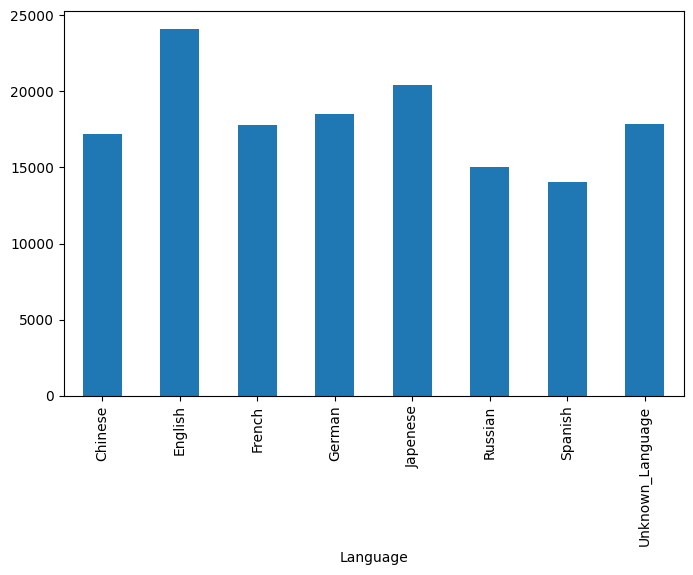

In [107]:
plt.figure(figsize=(8,5))
data.groupby('Language')['Page'].count().plot(kind='bar')
plt.show()

In [108]:
data['Language'].value_counts(normalize=True)*100

Language
English             16.618986
Japenese            14.084225
German              12.785479
Unknown_Language    12.308445
French              12.271909
Chinese             11.876909
Russian             10.355501
Spanish              9.698545
Name: proportion, dtype: float64

- 16.62% of webpages are in english followed by Japanese with 14%.
- But there are more than 12% of webpages whose language is not known.

In [109]:
data['Access_origin'].value_counts(normalize=True)*100

Access_origin
all-agents    75.932526
spider        24.067474
Name: proportion, dtype: float64

In [110]:
acc_orig=data.groupby('Access_origin')['Page'].count()
acc_orig

Access_origin
all-agents    110150
spider         34913
Name: Page, dtype: int64

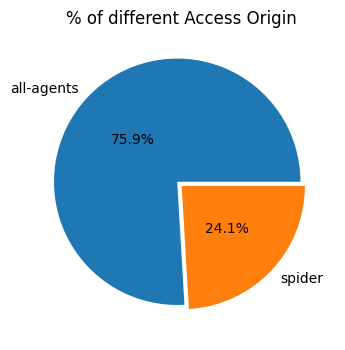

In [111]:
plt.figure(figsize=(4,4))
plt.pie(x=acc_orig.values,labels=acc_orig.index,autopct='%1.1f%%', pctdistance=0.5,explode=(0.05,0))
plt.title("% of different Access Origin")
plt.show()

- Only less than a quarter of webpages has access origin as spider.

In [112]:
data['Access_type'].value_counts(normalize=True)*100

Access_type
all-access    51.229466
mobile-web    24.774753
desktop       23.995781
Name: proportion, dtype: float64

In [113]:
acc_type=data.groupby('Access_type')['Page'].count()
acc_type

Access_type
all-access    74315
desktop       34809
mobile-web    35939
Name: Page, dtype: int64

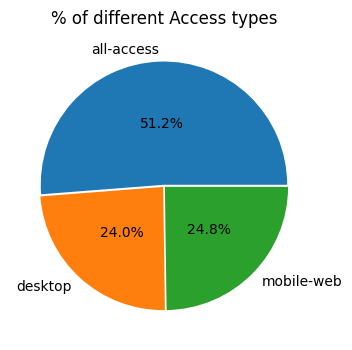

In [114]:
plt.figure(figsize=(4,4))
plt.pie(x=acc_type.values,labels=acc_type.index,autopct='%1.1f%%', pctdistance=0.5,explode=(0.01,0.01,0.01))
plt.title("% of different Access types")
plt.show()

- 24.8% of web pages have been accessed using mobile-web.
- 24% o web pages have been accesssed using desktop.
- While the remaining 51.2% is accessed by both.

In [115]:
data.groupby(['Access_type','Access_origin'])['Page'].count()

Access_type  Access_origin
all-access   all-agents       39402
             spider           34913
desktop      all-agents       34809
mobile-web   all-agents       35939
Name: Page, dtype: int64

In [116]:
data1= pd.DataFrame(data.groupby(['Language','Access_type'])['Page'].count().unstack())

In [117]:
data1

Access_type,all-access,desktop,mobile-web
Language,,,
Chinese,8620,4269,4340
English,14350,4975,4783
French,8999,4047,4756
German,9173,4640,4734
Japenese,10013,5562,4856
Russian,7484,3809,3729
Spanish,7074,3270,3725
Unknown_Language,8602,4237,5016


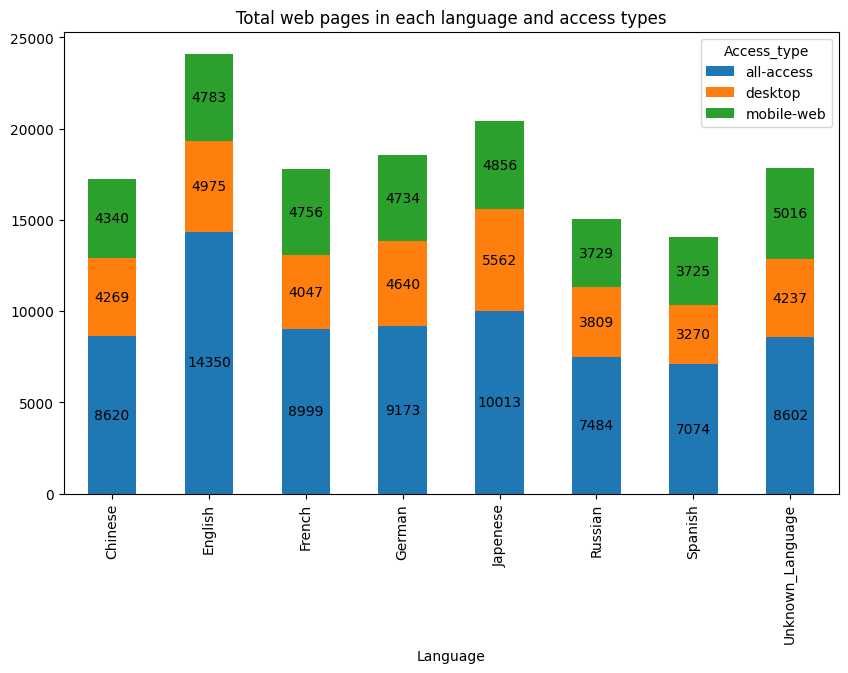

In [118]:
ax=data1.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding the annotations
for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.title("Total web pages in each language and access types")
plt.show()

- The proportion of desktop and mobile-web access seems to be similar across different languages.

In [119]:
data2= pd.DataFrame(data.groupby(['Language','Access_origin'])['Page'].count().unstack())
data2

Access_origin,all-agents,spider
Language,,
Chinese,12919,4310
English,19177,4931
French,13302,4500
German,13960,4587
Japenese,15424,5007
Russian,11280,3742
Spanish,10532,3537
Unknown_Language,13556,4299


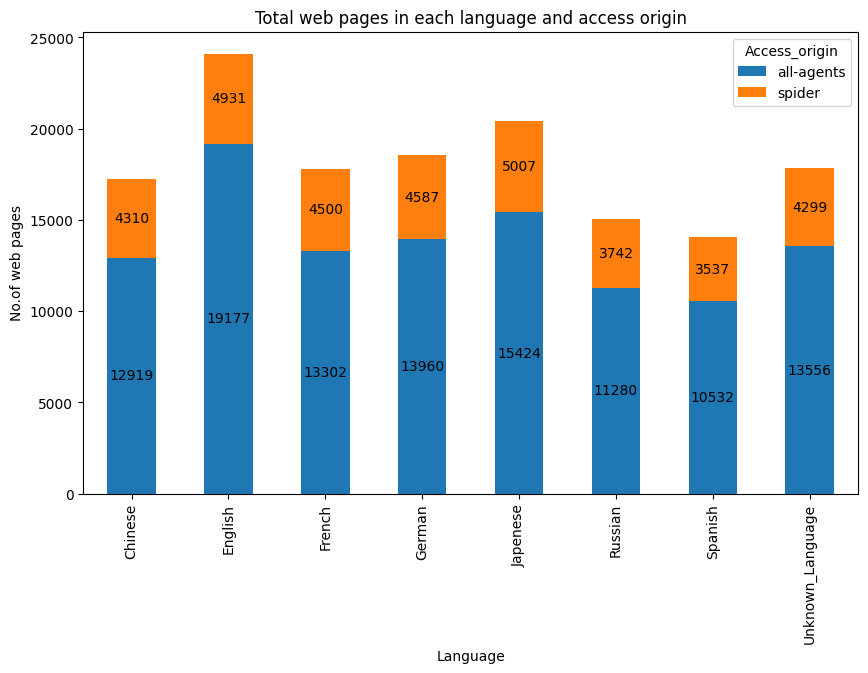

In [120]:
ax=data2.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding the annotations
for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.title("Total web pages in each language and access origin")
plt.ylabel("No.of web pages")
plt.show()

In [121]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Language,Access_origin,Access_type
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,26.0,14.0,20.0,22.0,19.0,18.0,20.0,Chinese,spider,all-access
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,15.0,9.0,30.0,52.0,45.0,26.0,20.0,Chinese,spider,all-access
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,7.0,4.0,4.0,6.0,3.0,4.0,17.0,Chinese,spider,all-access
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,27.0,16.0,11.0,17.0,19.0,10.0,11.0,Chinese,spider,all-access
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,3.0,11.0,27.0,13.0,36.0,10.0,Chinese,spider,all-access


- Let's drop the columns access origin, acces type and page and transform it to suit for time series analysis.


In [122]:
data = data.drop(columns=['Page','Access_origin','Access_type'])

##### Let's plot sum of the site visits on each day.

In [123]:
full_time_series = data.copy()

In [124]:
full_time_series = full_time_series.drop('Language',axis=1)

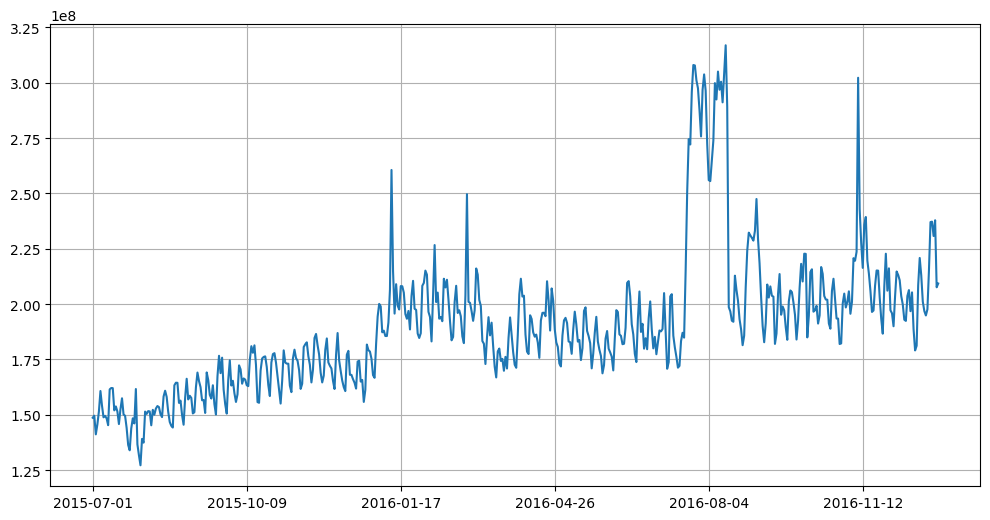

In [125]:
plt.figure(figsize=(12,6))
full_time_series.sum().plot()

plt.grid(True)
plt.show()

- There seems to be an upward trend in the web page visits data. This might not give a correct picture as there are different regions/languages web pages whose trend might be different from each other.

- Let's groupby language and then plot the means to find visualise the timeseries of each language.

In [126]:
# Groupby 'Language' and calculating the mean
mean_of_lang = data.groupby('Language').mean()
mean_of_lang

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
Language,,,,,,,,,,,,,,,,,,,,,
Chinese,240.582042,240.941958,239.344071,241.653491,257.779674,259.114864,258.832260,265.589529,263.964420,274.414592,...,345.165129,340.420338,360.738580,381.322886,376.447443,376.019618,378.048639,350.719427,354.704452,365.579256
English,3513.862203,3502.511407,3325.357889,3462.054256,3575.520035,3849.736021,3643.523063,3437.871080,3517.459391,3497.571594,...,4997.991248,4683.314294,4971.831757,5140.463373,5770.371661,6040.680728,5860.227559,6245.127510,5201.783018,5127.916418
French,475.150994,478.202000,459.837659,491.508932,482.557746,502.741209,485.945399,476.998820,472.061903,445.495057,...,652.004719,639.459443,618.215931,666.639085,936.884788,858.413100,774.155769,752.712954,700.543422,646.258342
German,714.968405,705.229741,676.877231,621.145145,722.076185,794.832480,770.814256,782.077641,752.939990,701.702593,...,828.738017,839.025934,810.756187,1281.088532,1206.478029,1085.095379,1032.640804,994.657141,949.265649,893.013425
Japenese,580.647056,666.672801,602.289805,756.509177,725.720914,632.399148,615.184181,611.462337,596.067642,619.299300,...,675.104792,968.007733,856.605012,818.374725,779.114728,789.158680,790.500465,865.483236,952.018354,1197.239440
Russian,629.999601,640.902876,594.026295,558.728132,595.029157,640.986287,626.293436,623.360205,638.550726,731.252297,...,896.352017,884.841299,874.274597,1120.990347,1112.840833,1001.209426,931.987685,897.282452,803.271868,880.244508
Spanish,1085.972919,1037.814557,954.412680,896.050750,974.508210,1110.637145,1082.568342,1050.669557,1030.841282,937.129931,...,983.568129,935.082522,880.307911,903.643685,1195.481626,1133.367901,1178.290923,1112.171085,821.671405,787.399531
Unknown_Language,83.479922,87.471857,82.680538,70.572557,78.214562,89.720190,94.939457,99.096724,86.445477,87.353906,...,131.521983,164.889051,140.363764,164.455167,165.821563,147.038925,186.438029,147.297004,164.540577,143.951442


In [127]:
means_data = mean_of_lang.T.reset_index()

In [128]:
means_data["index"] = pd.to_datetime(means_data["index"])
means_data = means_data.set_index("index")

In [129]:
means_data.head()

Language,Chinese,English,French,German,Japenese,Russian,Spanish,Unknown_Language
index,,,,,,,,
2015-07-01,240.582042,3513.862203,475.150994,714.968405,580.647056,629.999601,1085.972919,83.479922
2015-07-02,240.941958,3502.511407,478.202000,705.229741,666.672801,640.902876,1037.814557,87.471857
2015-07-03,239.344071,3325.357889,459.837659,676.877231,602.289805,594.026295,954.412680,82.680538
2015-07-04,241.653491,3462.054256,491.508932,621.145145,756.509177,558.728132,896.050750,70.572557
2015-07-05,257.779674,3575.520035,482.557746,722.076185,725.720914,595.029157,974.508210,78.214562


In [130]:
means_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 550 entries, 2015-07-01 to 2016-12-31
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Chinese           550 non-null    float64
 1   English           550 non-null    float64
 2   French            550 non-null    float64
 3   German            550 non-null    float64
 4   Japenese          550 non-null    float64
 5   Russian           550 non-null    float64
 6   Spanish           550 non-null    float64
 7   Unknown_Language  550 non-null    float64
dtypes: float64(8)
memory usage: 38.7 KB


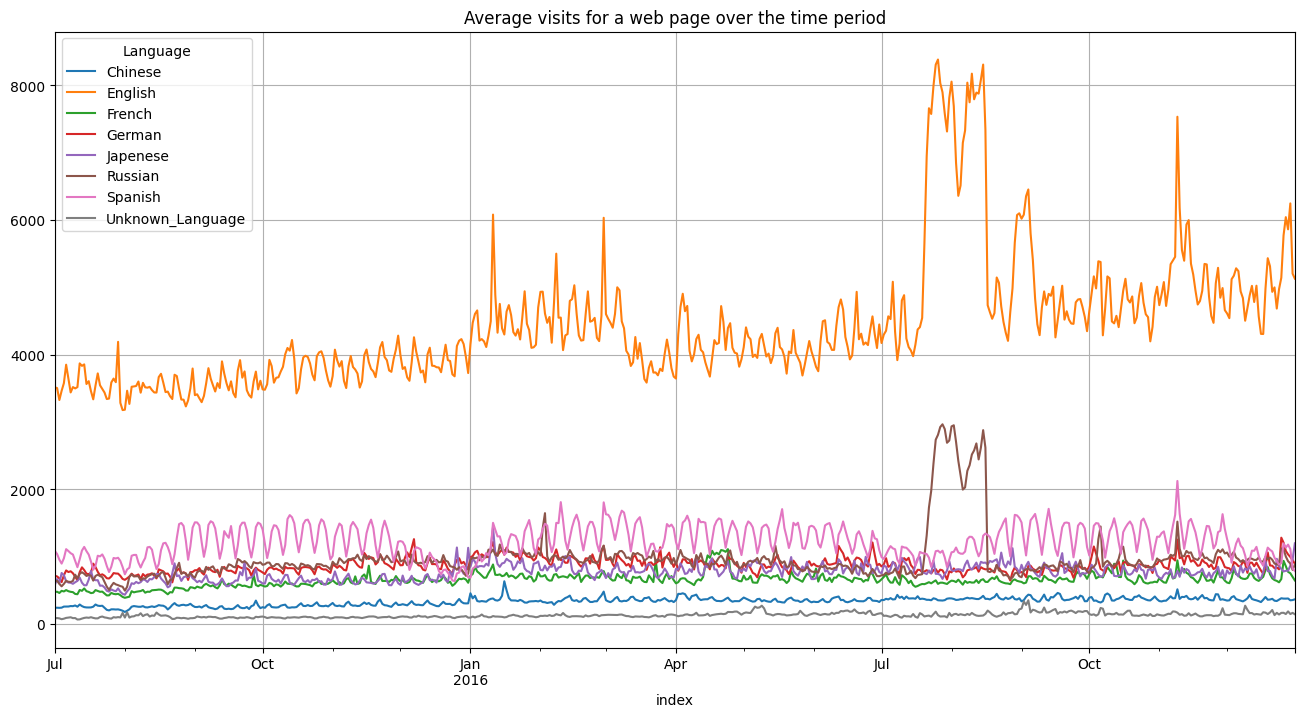

In [131]:
means_data.plot(figsize=(16,8))
plt.title("Average visits for a web page over the time period")
plt.grid(True)

plt.show()

## Is the Time Series Stationary or Trending :

#### Hypothesis Testing :

 - Null Hypothesis: The series is Non-Stationary

 - Alternative Hypothesis: The series is Stationary

 - significance level : 0.05 (alpha)

In [132]:
from statsmodels.tsa.stattools import adfuller

In [133]:
# Function to perform the Dickey-Fuller test and return the p-value
def perform_adfuller(series,signficance_level):
    p_value = adfuller(series)[1]
    if p_value <= signficance_level:
        print("Time Series is Stationary")
    else:
        print("Time Series is NOT Stationary")
    print("P_value is: ", p_value)
    return p_value

In [134]:
# Perform the test for each column
for column in means_data.columns:
    print(f'\nResults of Dickey-Fuller Test for {column}:')
    p_value = perform_adfuller(means_data[column],0.05)


Results of Dickey-Fuller Test for Chinese:
Time Series is NOT Stationary
P_value is:  0.44744579229311227

Results of Dickey-Fuller Test for English:
Time Series is NOT Stationary
P_value is:  0.18953359279992382

Results of Dickey-Fuller Test for French:
Time Series is NOT Stationary
P_value is:  0.051495021952457226

Results of Dickey-Fuller Test for German:
Time Series is NOT Stationary
P_value is:  0.14097382319729485

Results of Dickey-Fuller Test for Japenese:
Time Series is NOT Stationary
P_value is:  0.10257133898557619

Results of Dickey-Fuller Test for Russian:
Time Series is Stationary
P_value is:  0.0018649376536617886

Results of Dickey-Fuller Test for Spanish:
Time Series is Stationary
P_value is:  0.033588590844791

Results of Dickey-Fuller Test for Unknown_Language:
Time Series is Stationary
P_value is:  0.016293558379490952


- From the above Dickey-Fuller test, it can be osberved that only the time series of Russian, spanish language site visits are stationary.

## Time Series analysis for English language web pages:

- Let's create a dataset with only details of english language web pages.

In [135]:
english_TS = means_data.English

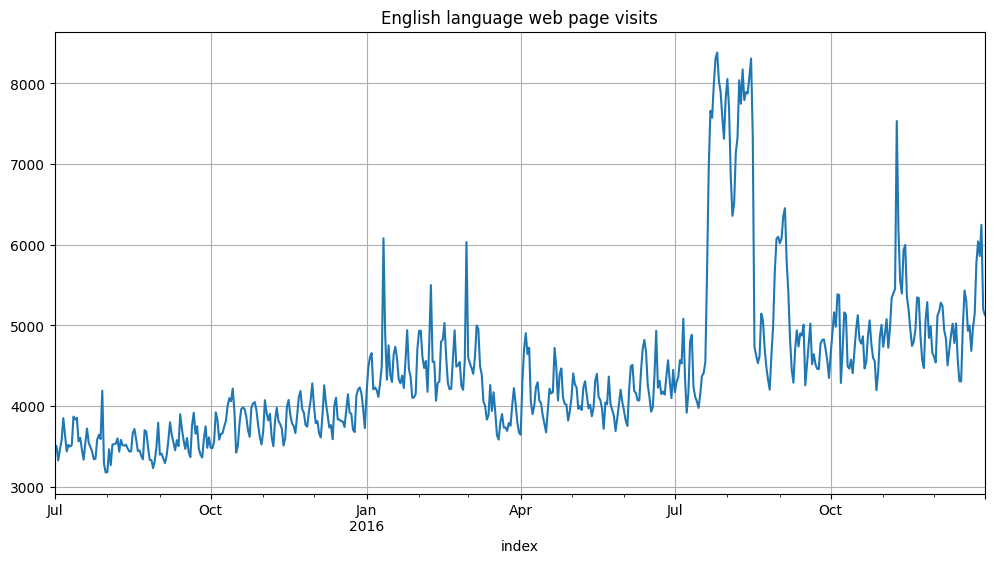

In [136]:
plt.figure(figsize=(12,6))
english_TS.plot()
plt.title("English language web page visits")
plt.grid(True)

plt.show()

## Time Series Decomposition:

Time series = trend + seasonality + residuals(errors)

Y(t)        =    b(t) + s(t)  + e(t)

#### Let's check if the data has any seasonality or not by plotting smaller intervals.

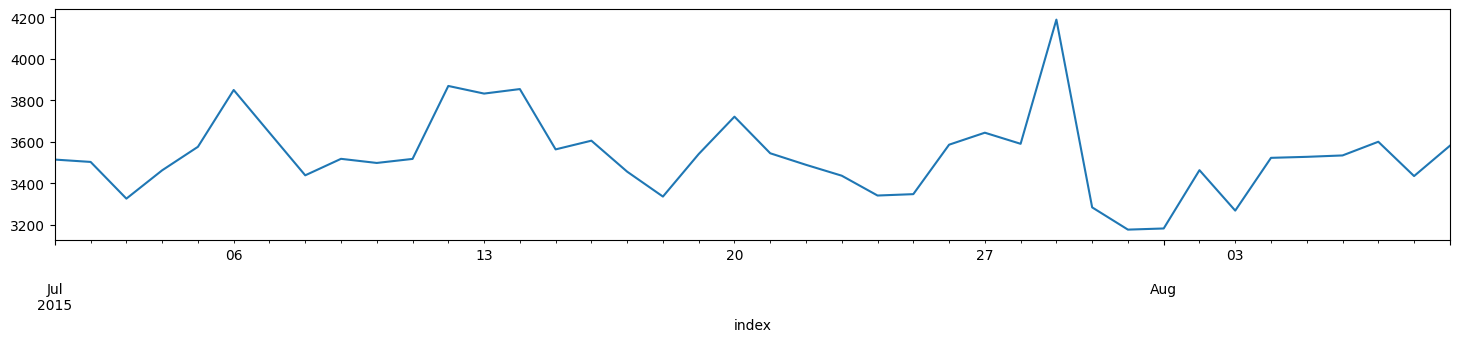

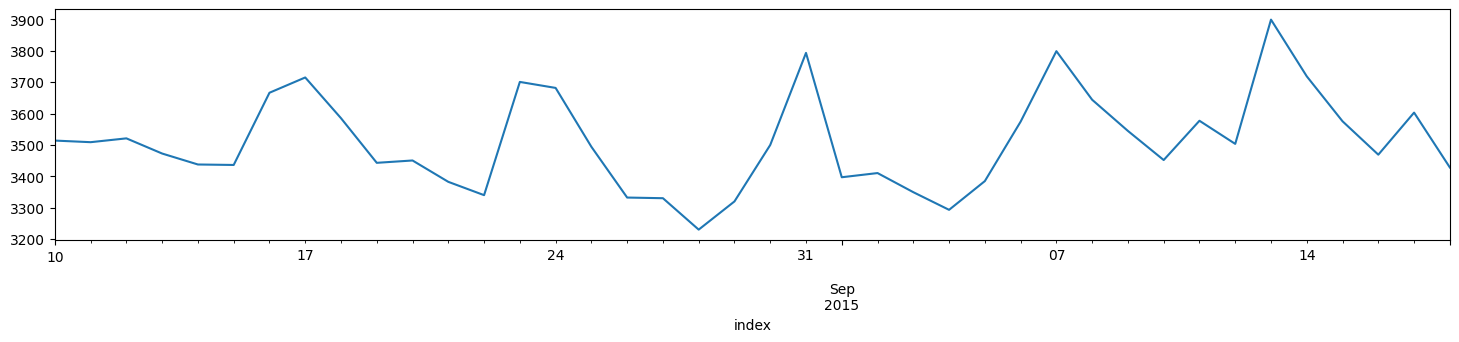

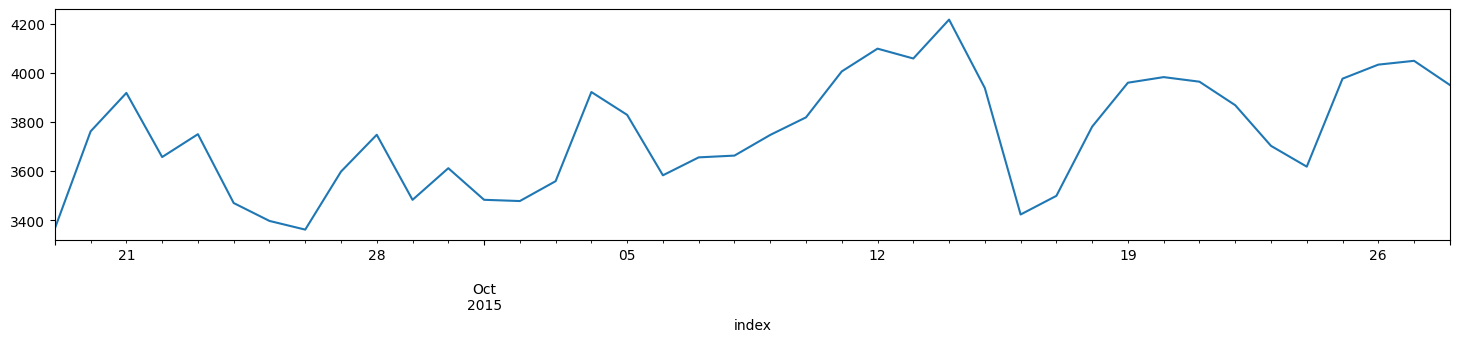

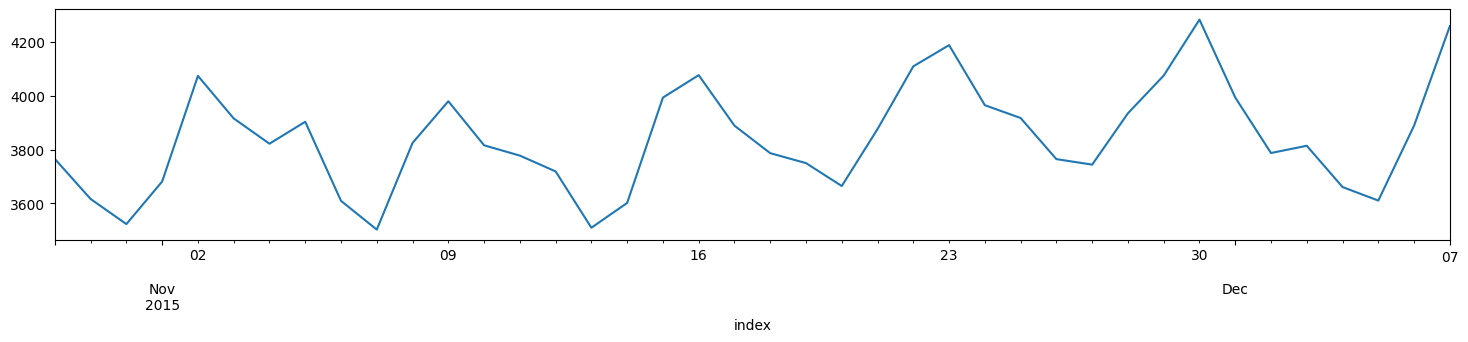

In [137]:
plt.rcParams['figure.figsize'] = (18, 3)

english_TS[:40].plot()
plt.show()

english_TS[40:80].plot()
plt.show()

english_TS[80:120].plot()
plt.show()

english_TS[120:160].plot()
plt.show()

- In the above plots, we can observe that there is a local peak at almost every 7th day. So, there is a high possibility of 7 days seasonality.

#### Let's plot ACF and PACF

In [138]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

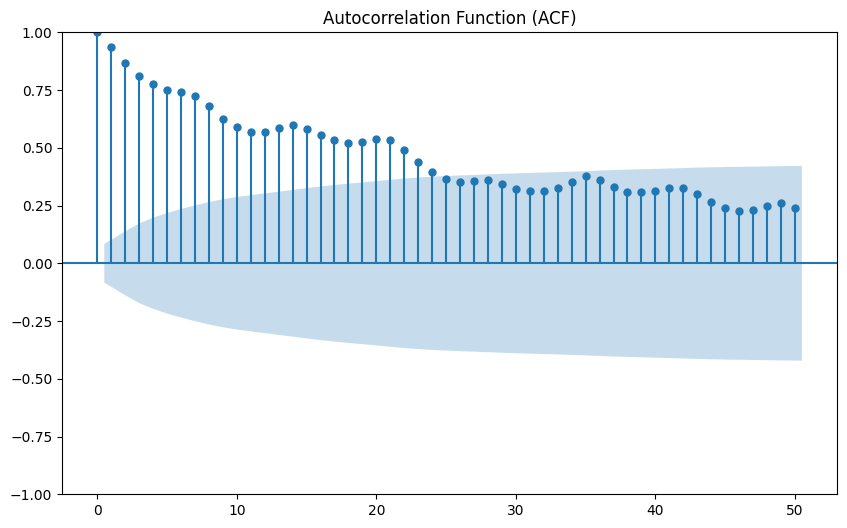

In [139]:
# Plot ACF
fig, ax = plt.subplots(figsize=(10, 6))

plot_acf(english_TS, lags=50,ax=ax)
plt.title('Autocorrelation Function (ACF)')
plt.show()

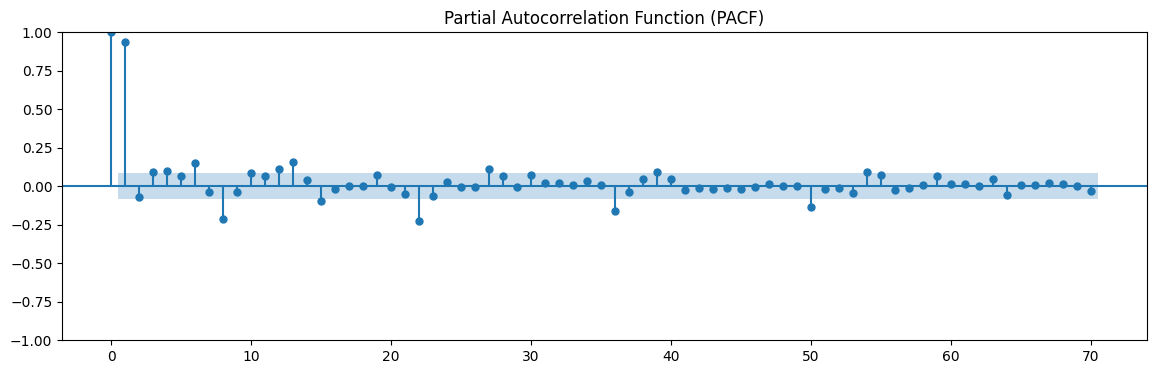

In [140]:
# Plot PACF
fig, ax = plt.subplots(figsize=(14, 4))
plot_pacf(english_TS, lags=70, method='ywm',ax=ax)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

- In ACF plot, a small spikes can be observed on every 7th value. Similar pattern can also be observed in major part of PACF plot as well.

#### Seasonal decomposition:

In [141]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [142]:
# Perform seasonal decomposition
decomp_model = seasonal_decompose(english_TS, model='additive', period=7)

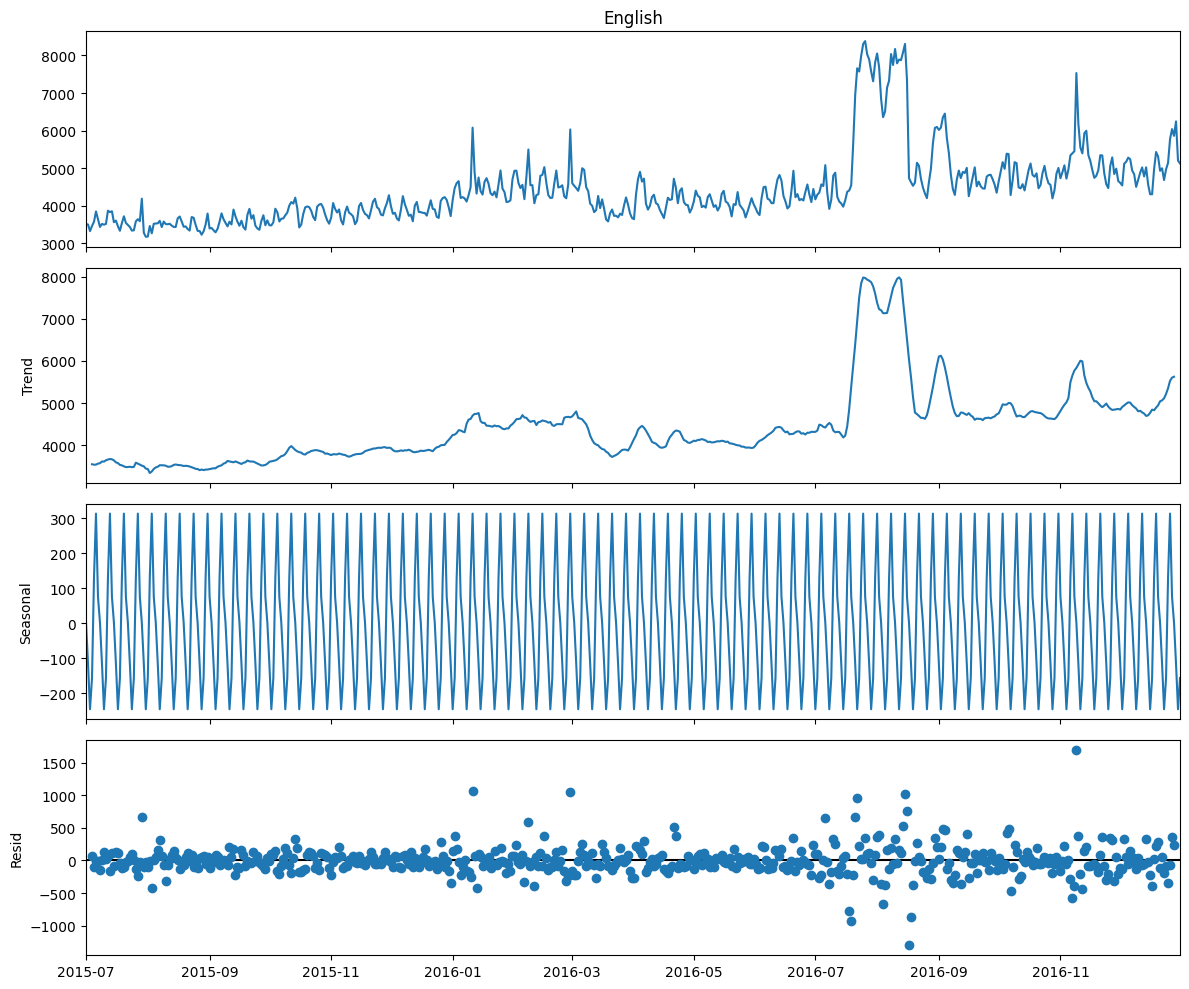

In [143]:
plt.rcParams['figure.figsize'] = (12, 10)
decomp_model.plot();

- Let's check for the stationarity of the decomposed time series.

In [144]:
p_value = perform_adfuller(pd.Series(decomp_model.seasonal).fillna(0),0.05)

Time Series is Stationary
P_value is:  0.0


In [145]:
p_value = perform_adfuller(pd.Series(decomp_model.resid).fillna(0),0.05)

Time Series is Stationary
P_value is:  3.727526947812949e-21


- Residuals of the decomposed time series is stationary.

#### Time series Differencing:

In [146]:
# Perform first-order differencing
english_TS_diff = english_TS.diff(1).dropna()

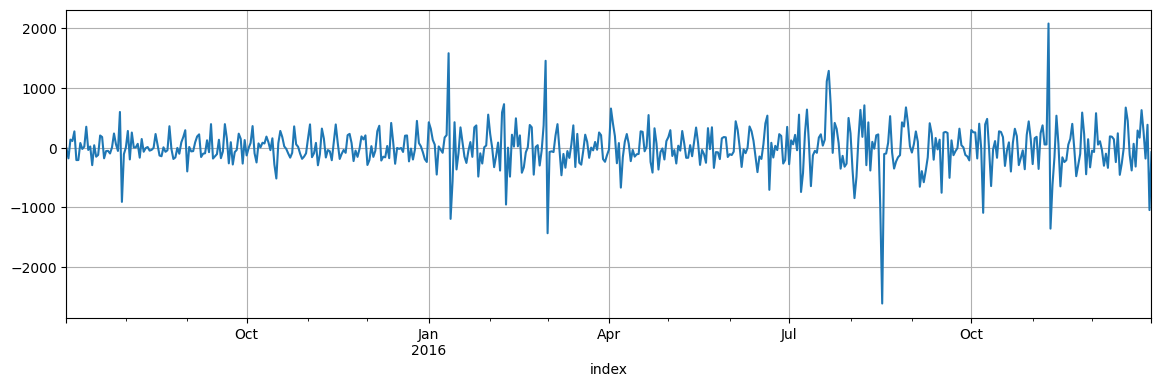

In [147]:
plt.rcParams['figure.figsize'] = (14, 4)

english_TS_diff.plot()
plt.grid(True)
plt.show()

In [148]:
p_value = perform_adfuller(pd.Series(english_TS_diff).fillna(0),0.05)

Time Series is Stationary
P_value is:  5.292474635436557e-13


## Forecasting

##### Function to calculate model evaluation metrics

In [149]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)

In [150]:
# Creating a function to calculate model evaluation metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 4))
    print('RMSE :', round(np.sqrt(mse(actual, predicted)), 4))
    print('MAPE:', round(mape(actual, predicted), 4))

#### Triple Exponential Smoothing:

In [151]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

##### Train - Test Split:

In [152]:
train_x = english_TS.loc[english_TS.index < english_TS.index[-30]].copy()
test_x = english_TS.loc[english_TS.index >= english_TS.index[-30]].copy()

MAE : 357.7468
RMSE : 519.0338
MAPE: 0.0662


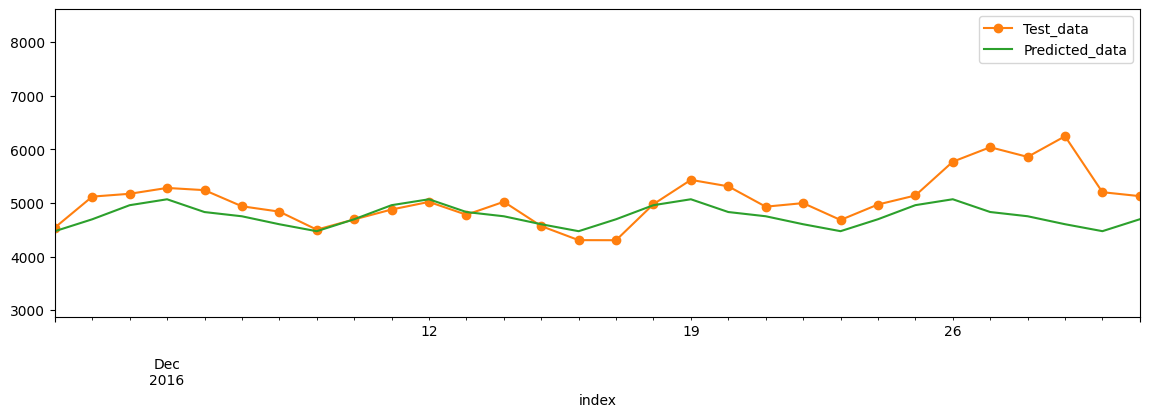

In [153]:
model = ExponentialSmoothing(train_x,trend='add',seasonal='add',seasonal_periods=7).fit()
model.fittedvalues.plot()

# X_test.plot()
Pred = model.forecast(steps=30)
performance(test_x,Pred)

test_x.plot(style="-o",label ="Test_data")
Pred.plot(label="Predicted_data")
plt.xlim(test_x.index[0], test_x.index[-1])
plt.legend()
plt.show()

- Triple Exponential Smoothing model was able to attain MAPE of 0.0662, which is well in asked range of 4 - 8 %.

### ARIMA:

In [154]:
from statsmodels.tsa.arima.model import ARIMA

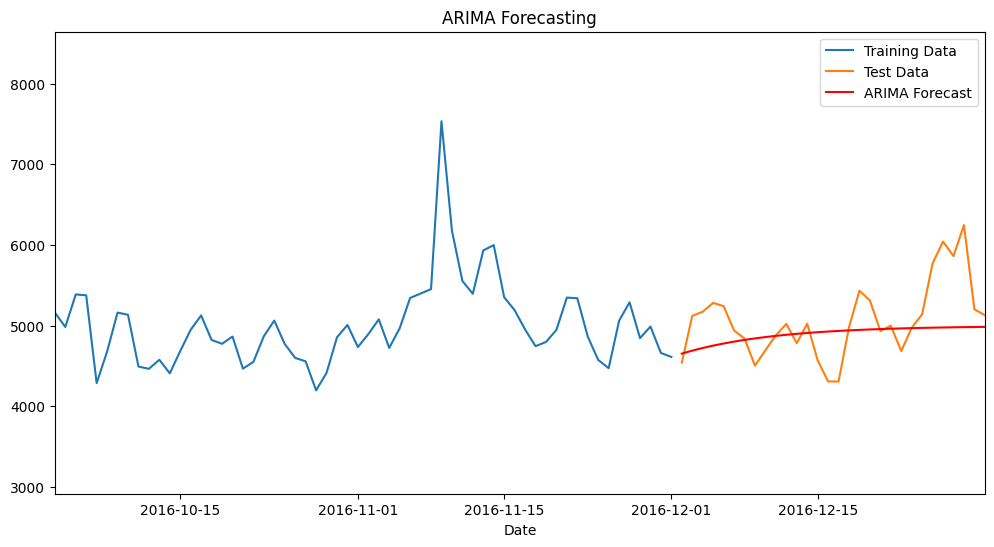

MAE : 346.0364
RMSE : 472.1862
MAPE: 0.0659


In [155]:
# Fit ARIMA model
arima_model = ARIMA(train_x, order=(1, 1, 1))  # p=1, d=1, q=1
arima_fit = arima_model.fit()

# Forecast the next 30 days
forecast = arima_fit.forecast(steps=30)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_x.index, train_x, label='Training Data')
plt.plot(test_x.index, test_x, label='Test Data')
plt.plot(test_x.index, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.xlim(train_x.index[-60], test_x.index[-1])

plt.legend()
plt.show()

performance(test_x,forecast)

- ARIMA model was able to attain MAPE of 0.0659, which is well in asked range of 4 - 8 %.

### SARIMAX

In [156]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [157]:
def sarimax_model(series, n, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog = []):

    #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s)
    sarimax_model = SARIMAX(series[:-n], \
                    order =(p,d,q),
                    seasonal_order=(P, D, Q, s),
                    exog = exog[:-n],
                    initialization='approximate_diffuse')
    sarimax_model_fit = sarimax_model.fit()

    #Creating forecast for last n-values
    model_forecast = sarimax_model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))

    #plotting Actual & Forecasted values

    plt.figure(figsize = (20,8))
    series[-60:].plot(label = 'Actual')
    model_forecast[-60:].plot(label = 'Forecast', color = 'red',
                              linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
    plt.legend(loc="upper right")
    plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
    plt.show()
    performance(test_x,model_forecast)

In [158]:
english_TS.index.freq = 'D'

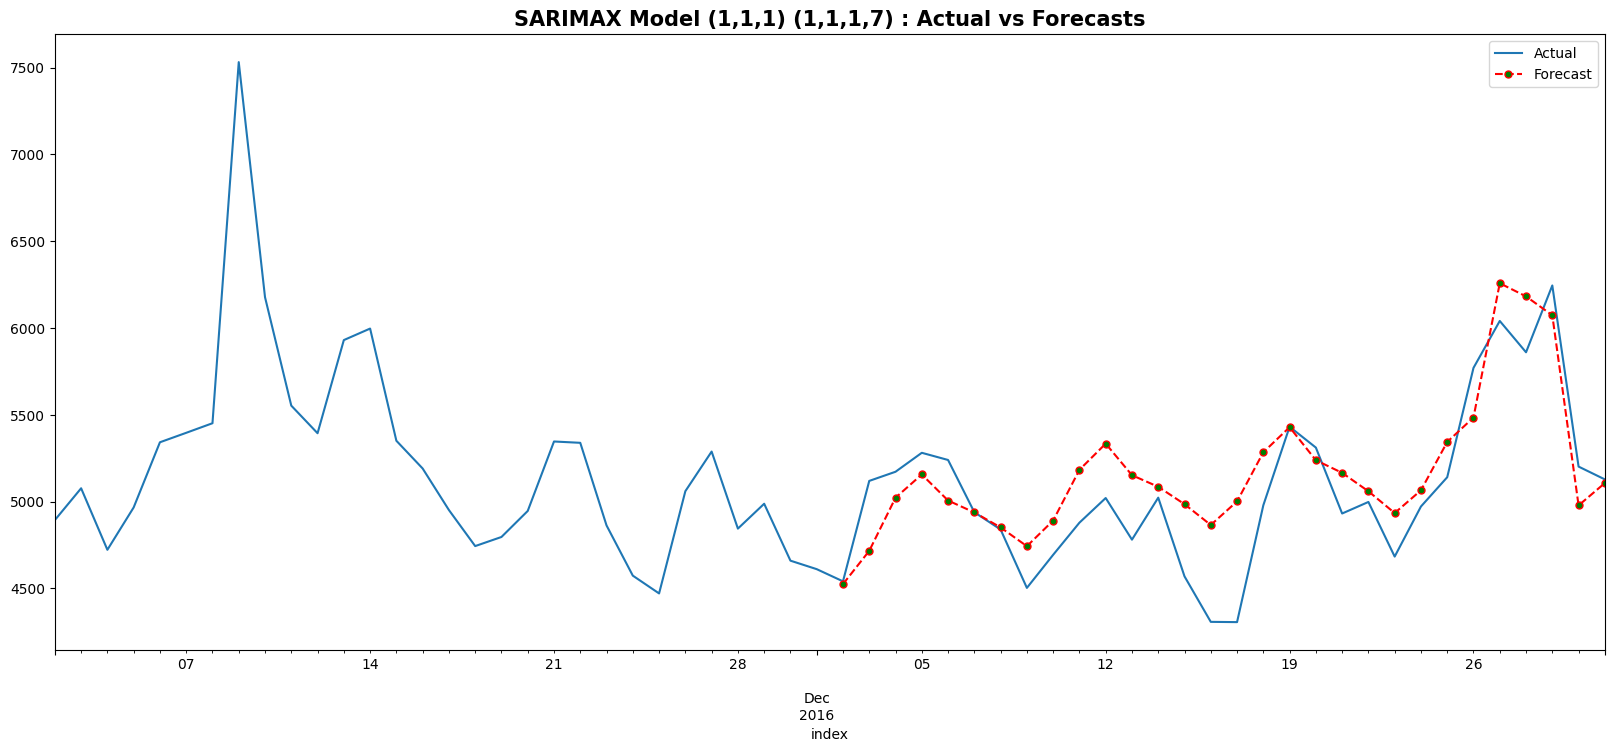

MAE : 218.8412
RMSE : 272.9837
MAPE: 0.0446


In [159]:
exog = Exog_Campaign_eng['Exog'].to_numpy()
p,d,q, P,D,Q,s = 1,1,1,1,1,1,7
series = english_TS
n = 30
sarimax_model(series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

#### Hyperparameter tuning for SARIMAX using grid search:

In [160]:
def SARIMAX_grid_search(time_series, n, param, d_param, s_param, exog = []):
    counter = 0
    #creating df for storing results summary
    param_df = pd.DataFrame(columns = ['serial','pdq', 'PDQs', 'mape', 'rmse'])

    #Creating loop for every paramater to fit SARIMAX model
    for p in param:
        for d in d_param:
            for q in param:
                for P in param:
                    for D in d_param:
                        for Q in param:
                            for s in s_param:
                                #Creating Model
                                model = SARIMAX(time_series[:-n],
                                                order=(p,d,q),
                                                seasonal_order=(P, D, Q, s),
                                                exog = exog[:-n],
                                                initialization='approximate_diffuse')
                                model_fit = model.fit()

                                #Creating forecast from Model
                                model_forecast = model_fit.forecast(n, dynamic = True, exog = pd.DataFrame(exog[-n:]))

                                #Calculating errors for results
                                actuals = time_series.values[-n:]
                                errors = time_series.values[-n:] - model_forecast.values

                                #Calculating MAPE & RMSE
                                mape = np.mean(np.abs(errors)/ np.abs(actuals))
                                rmse = np.sqrt(np.mean(errors**2))
                                mape = np.round(mape,5)
                                rmse = np.round(rmse,3)

                                #Storing the results in param_df
                                counter += 1
                                list_row = [counter, (p,d,q), (P,D,Q,s), mape, rmse]
                                param_df.loc[len(param_df)] = list_row

                #print statement to check progress of Loop
                print(f'Possible Combination: {counter} out of { (len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

    return param_df

In [161]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.catch_warnings()
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [162]:
time_series = english_TS
n = 30
param = [0,1,2] #p,P,q,Q
d_param = [0,1] #d,D
s_param = [7] #s

english_params  = SARIMAX_grid_search(time_series, n, param, d_param,s_param, exog)

Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculated
Possible Combination: 324 out of 324 calculated


In [163]:
english_params.sort_values(['mape', 'rmse']).head()

,serial,pdq,PDQs,mape,rmse
239,240,"(2, 0, 1)","(0, 1, 2, 7)",0.03936,242.880
323,324,"(2, 1, 2)","(2, 1, 2, 7)",0.04025,250.688
40,41,"(0, 0, 2)","(0, 1, 1, 7)",0.04199,276.311
41,42,"(0, 0, 2)","(0, 1, 2, 7)",0.04206,271.577
46,47,"(0, 0, 2)","(1, 1, 1, 7)",0.04212,270.079


**Best Hyper parameters: 2,0,1,0,1,2,7**
- Let's use the above parameters that we got after hyper parameter tuning.

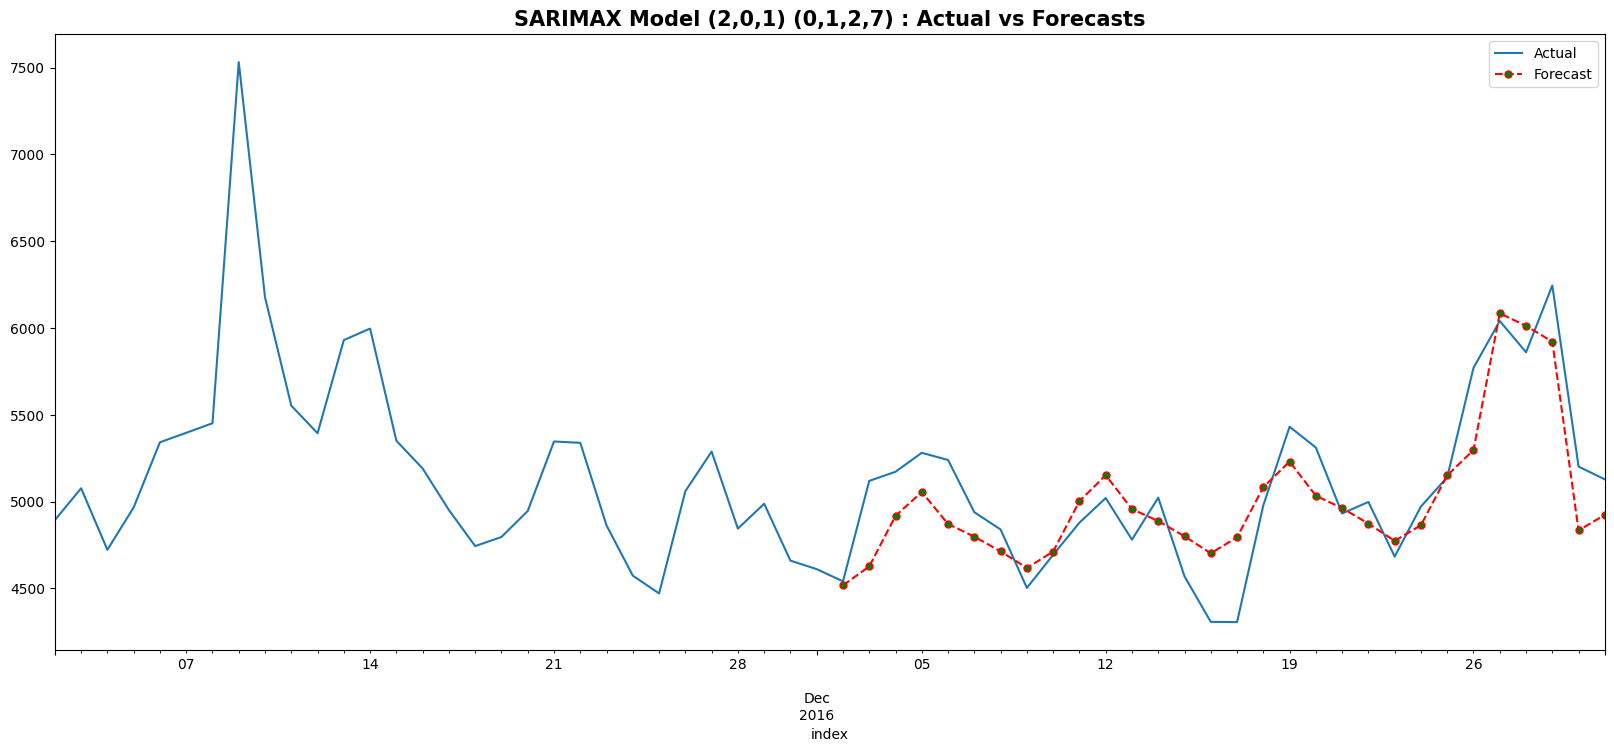

MAE : 198.5985
RMSE : 242.88
MAPE: 0.0394


In [164]:
time_series = english_TS
p,d,q, P,D,Q,s = 2,0,1,0,1,2,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

- We are able to create a model which is able to attain MAPE of 0.0394 which is even less than the asked 4 - 8%.

In [165]:
def sarimax_grid_search_all_lang(languages, data, n, param, d_param, s_param):

    best_param_df  = pd.DataFrame(columns = ['language','p','d', 'q', 'P','D','Q','s','mape'])
    for lang in languages:
        print('')
        print('')
        print(f'--------------------------------------------------------------')
        print(f'          Finding best parameters for {lang}                  ')
        print(f'--------------------------------------------------------------')
        counter = 0
        time_series = means_data[lang]
        best_mape = 100

        #Creating loop for every paramater to fit SARIMAX model
        for p in param:
            for d in d_param:
                for q in param:
                    for P in param:
                        for D in d_param:
                            for Q in param:
                                for s in s_param:
                                    #Creating Model
                                    model = SARIMAX(time_series[:-n],
                                                    order=(p,d,q),
                                                    seasonal_order=(P, D, Q, s),
                                                    initialization='approximate_diffuse')
                                    model_fit = model.fit()

                                    #Creating forecast from Model
                                    model_forecast = model_fit.forecast(n, dynamic = True)

                                    #Calculating errors for results
                                    actuals = time_series.values[-n:]
                                    errors = time_series.values[-n:] - model_forecast.values

                                    #Calculating MAPE & RMSE
                                    mape = np.mean(np.abs(errors)/ np.abs(actuals))

                                    counter += 1

                                    if (mape < best_mape):
                                        best_mape = mape
                                        best_p = p
                                        best_d = d
                                        best_q = q
                                        best_P = P
                                        best_D = D
                                        best_Q = Q
                                        best_s = s
                                    else: pass

                    #print statement to check progress of Loop
                    print(f'Possible Combination: {counter} out of {(len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

        best_mape = np.round(best_mape, 4)
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {lang} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p , best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')

        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_mape]
        best_param_df.loc[len(best_param_df)] = best_param_row

    return best_param_df

In [166]:
languages = means_data.columns
n = 30
param = [0,1,2]
d_param = [0,1]
s_param = [7]

best_param_df = sarimax_grid_search_all_lang(languages, means_data, n, param, d_param, s_param)



--------------------------------------------------------------
          Finding best parameters for Chinese                  
--------------------------------------------------------------
Possible Combination: 18 out of 324 calculated
Possible Combination: 36 out of 324 calculated
Possible Combination: 54 out of 324 calculated
Possible Combination: 72 out of 324 calculated
Possible Combination: 90 out of 324 calculated
Possible Combination: 108 out of 324 calculated
Possible Combination: 126 out of 324 calculated
Possible Combination: 144 out of 324 calculated
Possible Combination: 162 out of 324 calculated
Possible Combination: 180 out of 324 calculated
Possible Combination: 198 out of 324 calculated
Possible Combination: 216 out of 324 calculated
Possible Combination: 234 out of 324 calculated
Possible Combination: 252 out of 324 calculated
Possible Combination: 270 out of 324 calculated
Possible Combination: 288 out of 324 calculated
Possible Combination: 306 out of 324 calculat

- Among all the web pages, all languages achieved the required performance except for those with unknown languages.
- This could be due to multiple languages being missed during data recording, leading to them being grouped into a single time series instead of being separated.

In [167]:
best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,Chinese,0,1,0,1,0,2,7,0.0307
5,Russian,0,0,1,2,0,2,7,0.0427
1,English,2,0,1,0,1,2,7,0.0526
2,French,0,0,2,2,1,2,7,0.0636
3,German,0,1,1,1,0,1,7,0.0658
4,Japenese,0,1,2,2,1,0,7,0.0712
6,Spanish,0,1,0,2,1,0,7,0.0856
7,Unknown_Language,0,1,2,0,0,0,7,0.0976


- So let's remove the row that contains parameters of unknown language.

In [168]:
best_param_df = best_param_df.drop(index=7).reset_index(drop=True)

In [169]:
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,Chinese,0,1,0,1,0,2,7,0.0307
1,Russian,0,0,1,2,0,2,7,0.0427
2,English,2,0,1,0,1,2,7,0.0526
3,French,0,0,2,2,1,2,7,0.0636
4,German,0,1,1,1,0,1,7,0.0658
5,Japenese,0,1,2,2,1,0,7,0.0712
6,Spanish,0,1,0,2,1,0,7,0.0856


In [170]:
def SARIMAX_model_pred_plot(languages, data, n, best_param_df):

    for lang in languages:
        #fetching respective best parameters for that language
        p = best_param_df.loc[best_param_df['language'] == lang, ['p']].values[0][0]
        d = best_param_df.loc[best_param_df['language'] == lang, ['d']].values[0][0]
        q = best_param_df.loc[best_param_df['language'] == lang, ['q']].values[0][0]
        P = best_param_df.loc[best_param_df['language'] == lang, ['P']].values[0][0]
        D = best_param_df.loc[best_param_df['language'] == lang, ['D']].values[0][0]
        Q = best_param_df.loc[best_param_df['language'] == lang, ['Q']].values[0][0]
        s = best_param_df.loc[best_param_df['language'] == lang, ['s']].values[0][0]

        #Creating language time-series
        time_series = means_data[lang]

        #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s)
        model = SARIMAX(time_series[:-n],
                        order =(p,d,q),
                        seasonal_order=(P, D, Q, s),
                        initialization='approximate_diffuse')
        model_fit = model.fit()

        #Creating forecast for last n-values
        model_forecast = model_fit.forecast(n, dynamic = True)

        #Calculating MAPE & RMSE
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values

        mape = np.mean(np.abs(errors)/ np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))

        print('')
        print('')
        print(f'-----------------------------------------------------------------------------------------')
        print(f'        SARIMAX model for {lang} Time Series                                             ')
        print(f'        Parameters of Model : ({p},{d},{q}) ({P},{D},{Q},{s})                            ')
        print(f'        MAPE of Model       : {np.round(mape,4)}                                         ')
        print(f'        RMSE of Model       : {np.round(rmse,3)}                                         ')
        print(f'-----------------------------------------------------------------------------------------')

        #plotting Actual & Forecasted values
        time_series.index = time_series.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize = (20,8))
        time_series[-60:].plot(label = 'Actual')
        model_forecast[-60:].plot(label = 'Forecast', color = 'red',
                                  linestyle='dashed', marker='o',markerfacecolor='green', markersize=5)
        plt.legend(loc="upper right")
        plt.title(f'SARIMAX Model - {lang} - ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
        plt.show()




-----------------------------------------------------------------------------------------
        SARIMAX model for Chinese Time Series                                             
        Parameters of Model : (0,1,0) (1,0,2,7)                            
        MAPE of Model       : 0.0307                                         
        RMSE of Model       : 14.487                                         
-----------------------------------------------------------------------------------------


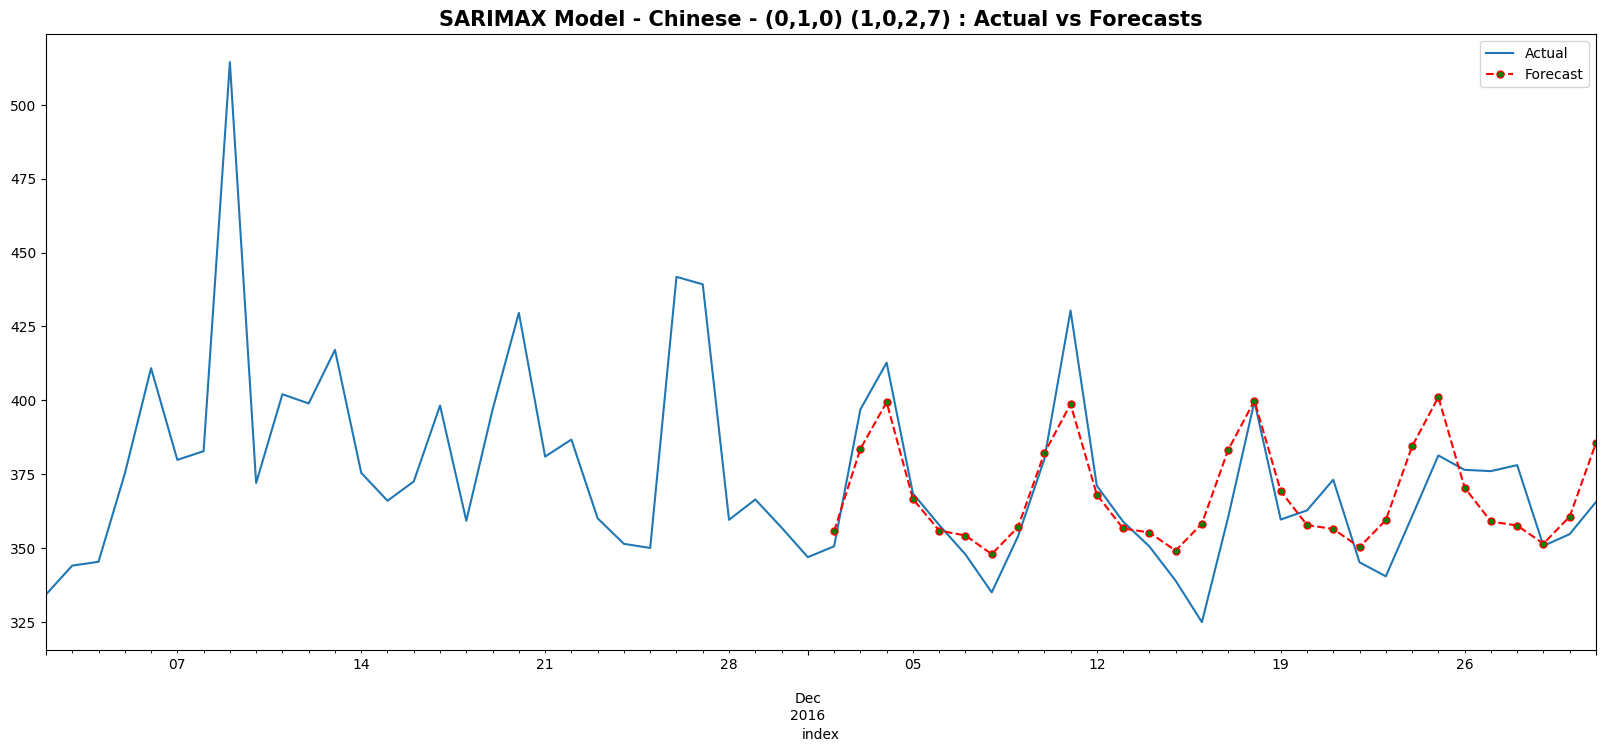



-----------------------------------------------------------------------------------------
        SARIMAX model for English Time Series                                             
        Parameters of Model : (2,0,1) (0,1,2,7)                            
        MAPE of Model       : 0.0526                                         
        RMSE of Model       : 387.196                                         
-----------------------------------------------------------------------------------------


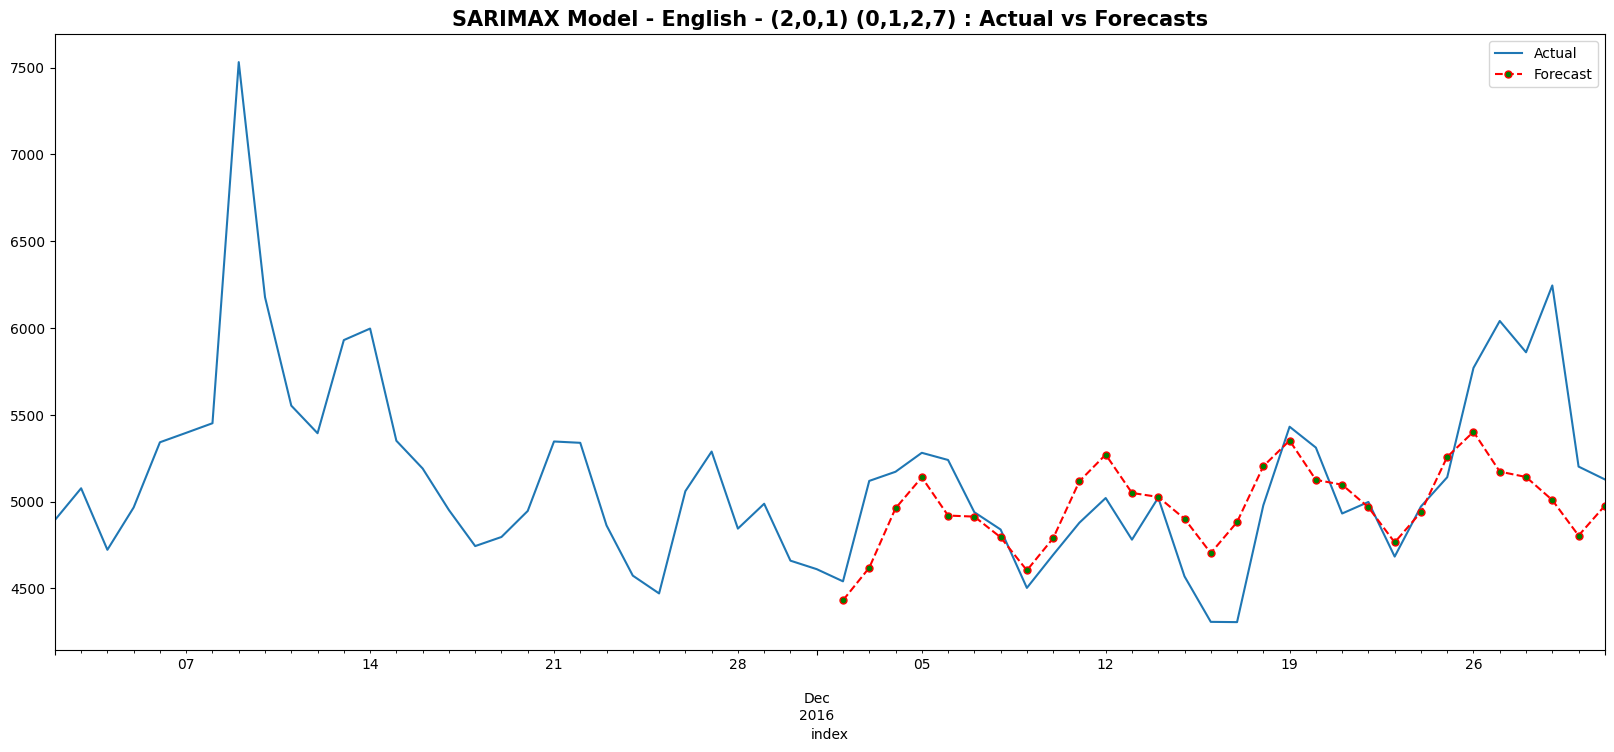



-----------------------------------------------------------------------------------------
        SARIMAX model for French Time Series                                             
        Parameters of Model : (0,0,2) (2,1,2,7)                            
        MAPE of Model       : 0.0636                                         
        RMSE of Model       : 72.605                                         
-----------------------------------------------------------------------------------------


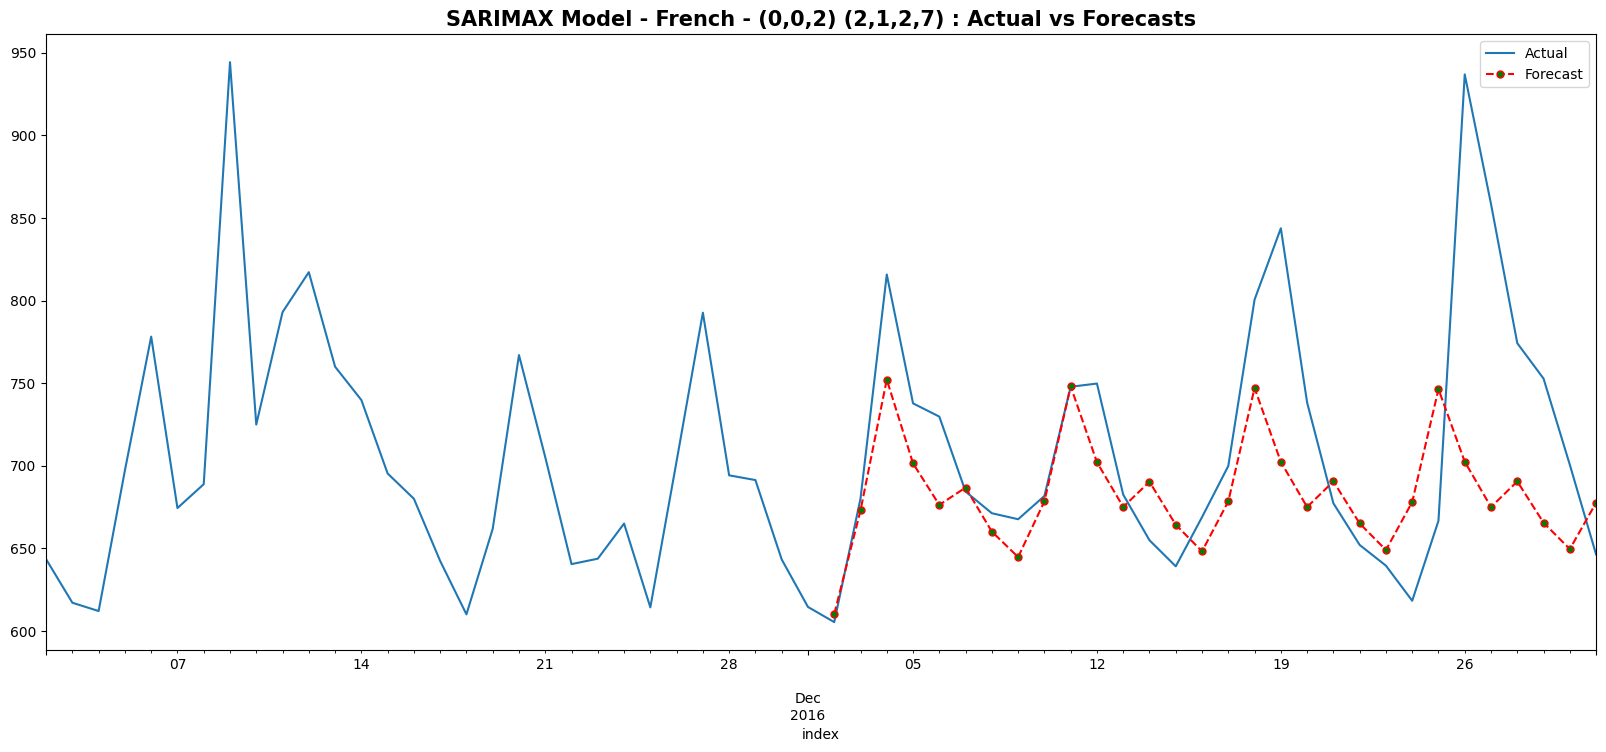



-----------------------------------------------------------------------------------------
        SARIMAX model for German Time Series                                             
        Parameters of Model : (0,1,1) (1,0,1,7)                            
        MAPE of Model       : 0.0658                                         
        RMSE of Model       : 110.621                                         
-----------------------------------------------------------------------------------------


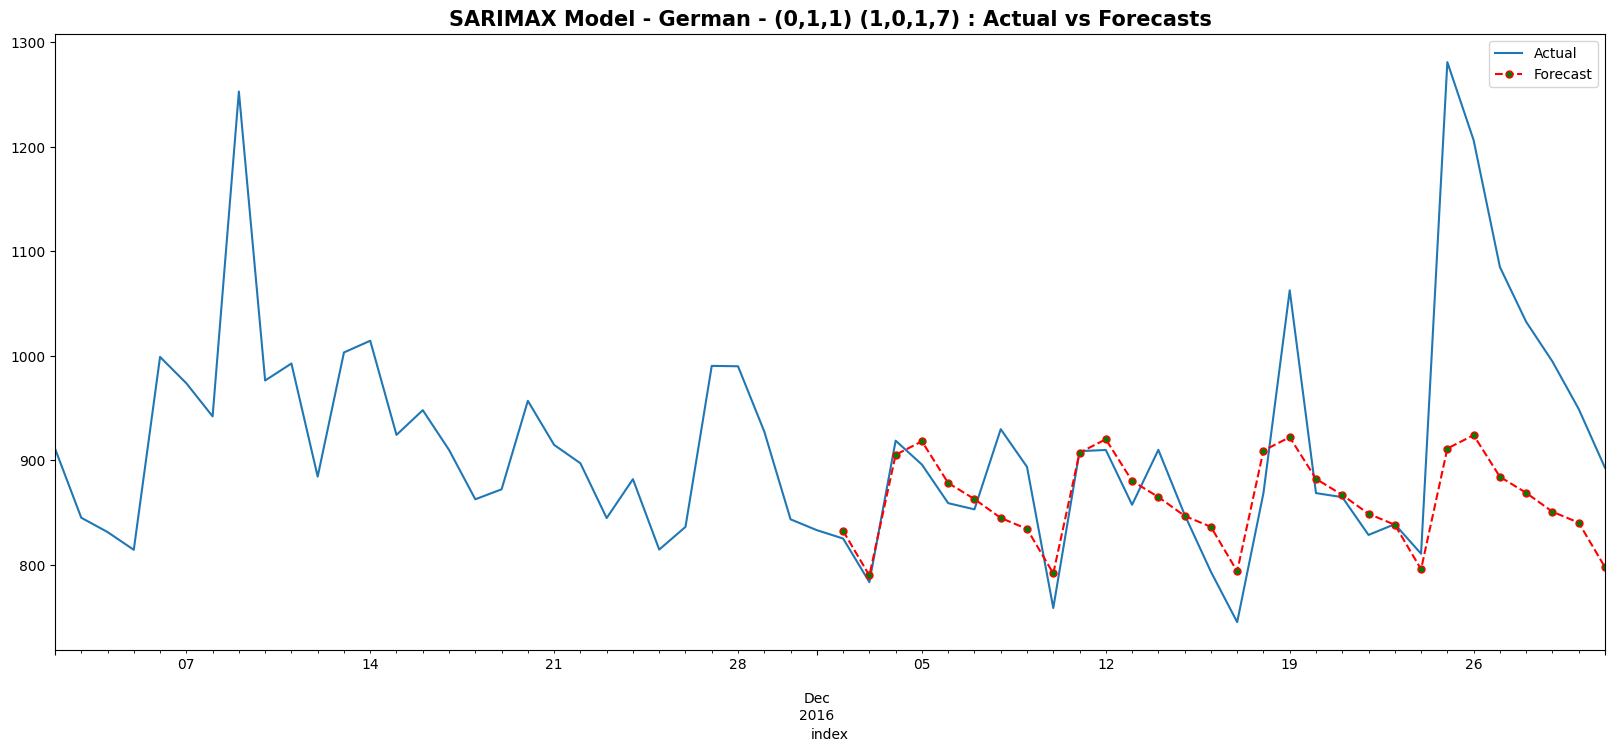



-----------------------------------------------------------------------------------------
        SARIMAX model for Japenese Time Series                                             
        Parameters of Model : (0,1,2) (2,1,0,7)                            
        MAPE of Model       : 0.0712                                         
        RMSE of Model       : 90.833                                         
-----------------------------------------------------------------------------------------


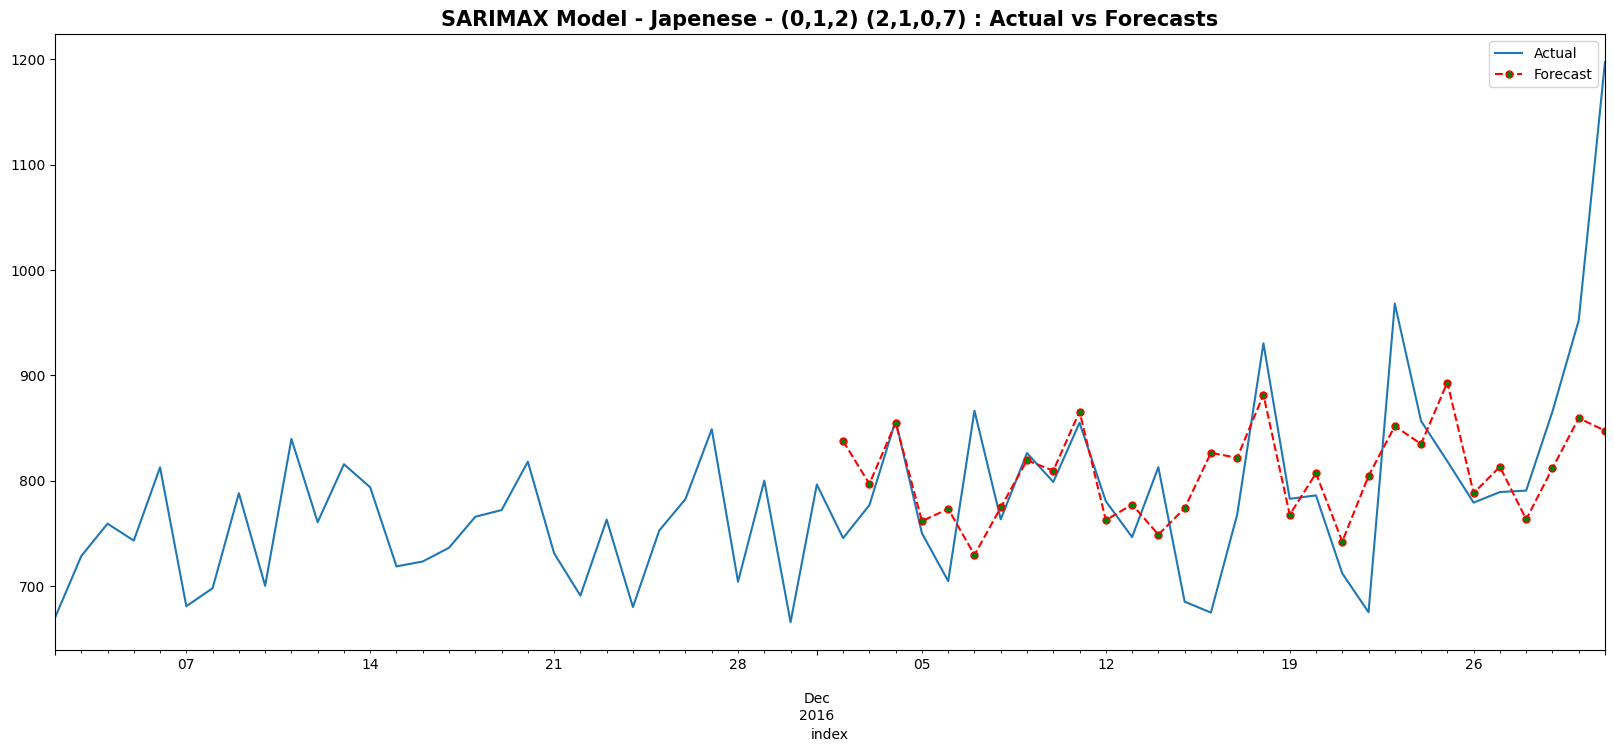



-----------------------------------------------------------------------------------------
        SARIMAX model for Russian Time Series                                             
        Parameters of Model : (0,0,1) (2,0,2,7)                            
        MAPE of Model       : 0.0427                                         
        RMSE of Model       : 56.737                                         
-----------------------------------------------------------------------------------------


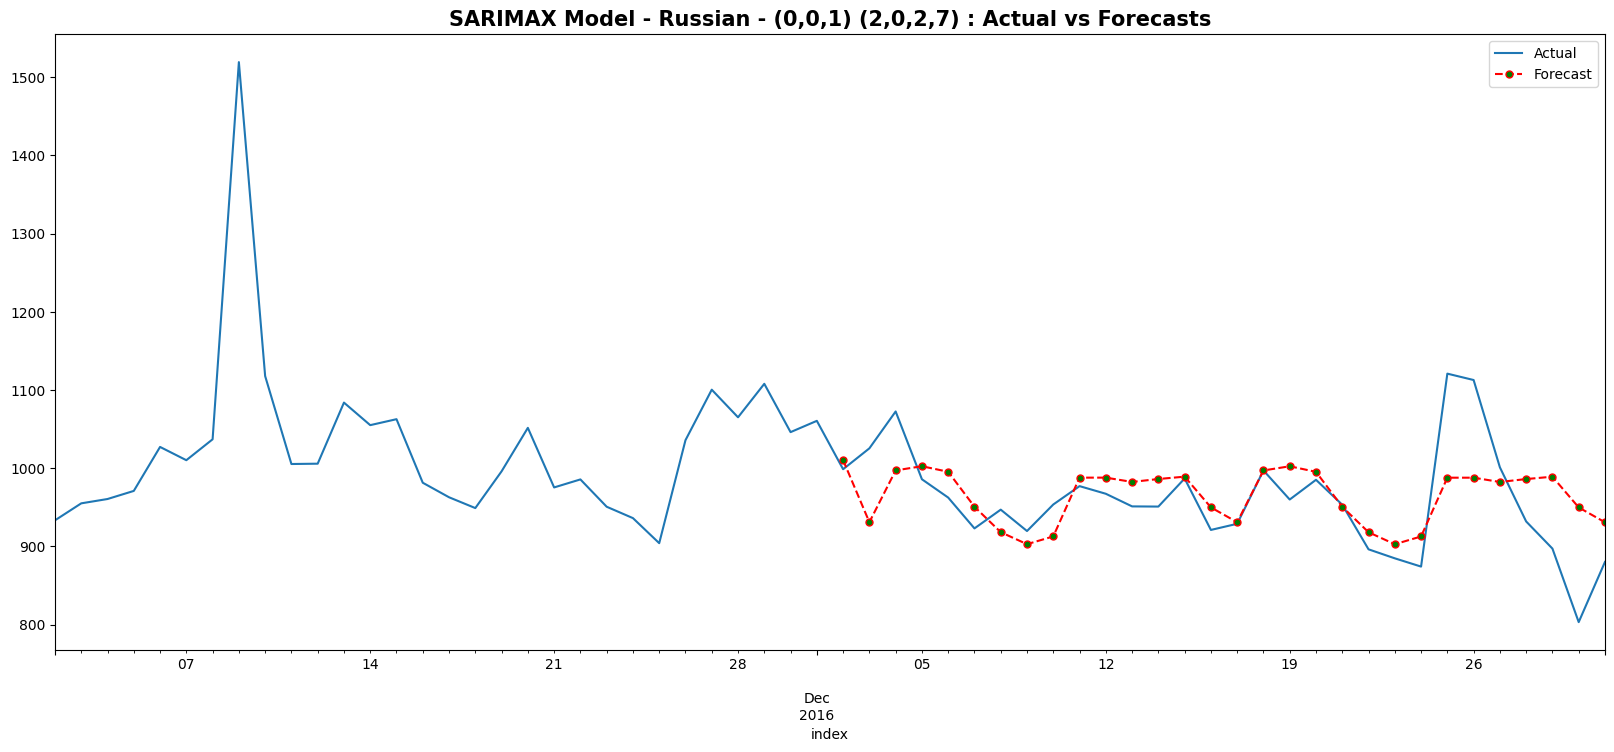



-----------------------------------------------------------------------------------------
        SARIMAX model for Spanish Time Series                                             
        Parameters of Model : (0,1,0) (2,1,0,7)                            
        MAPE of Model       : 0.0856                                         
        RMSE of Model       : 109.03                                         
-----------------------------------------------------------------------------------------


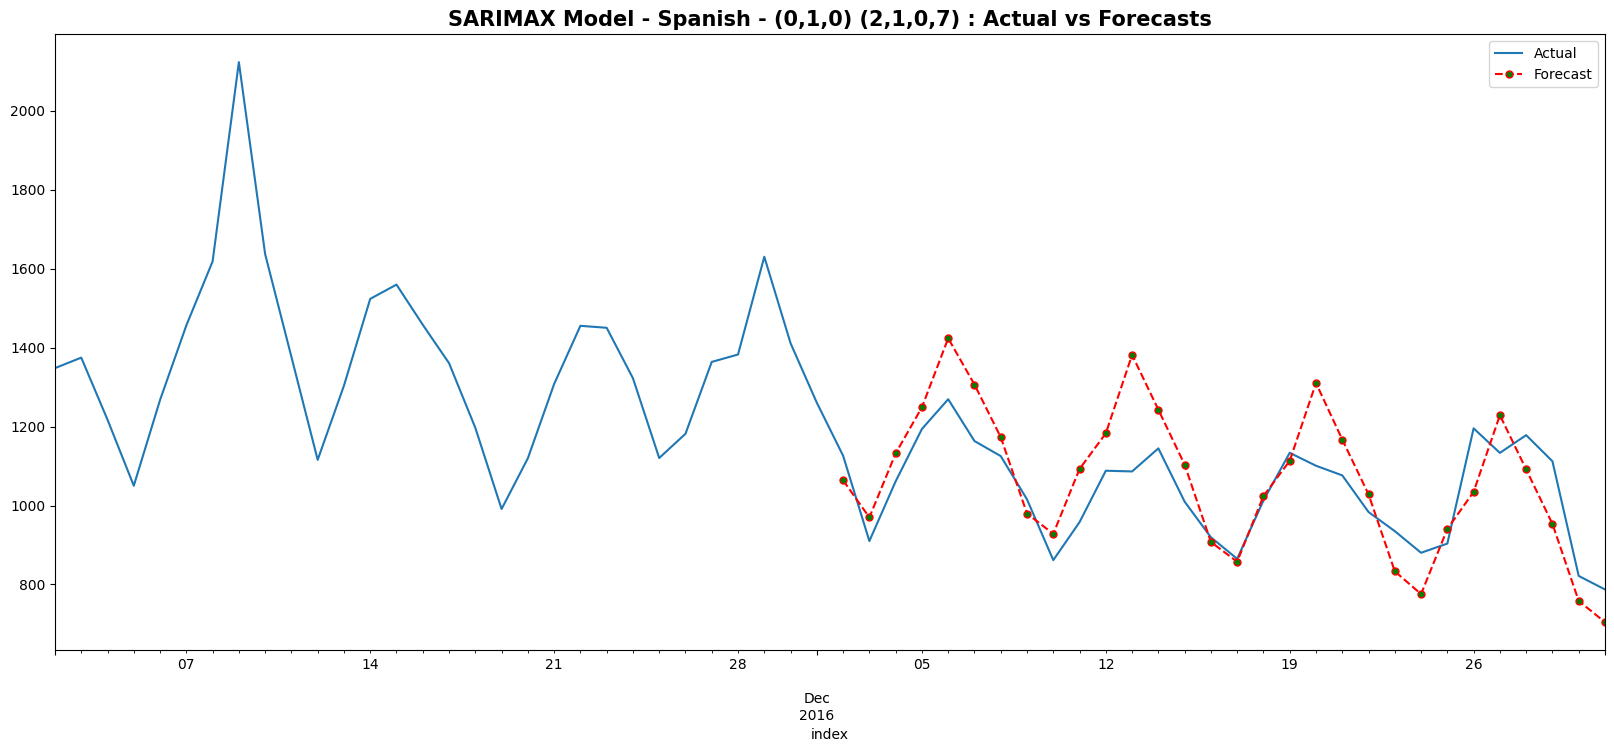

In [171]:
#Plotting SARIMAX model for each Language Time Series
languages = means_data.columns.drop('Unknown_Language')
n = 30
SARIMAX_model_pred_plot(languages, means_data, n, best_param_df)

### Facebook Prophet:

In [92]:
from prophet import Prophet

Prophet expects the data frame to have two columns: ds & y


*   ds (datestamp): A column of dates
*   y: The value to be forecasted

In [100]:
# Let's create a dataset suitable for facebook prophet.


TS_prophet = means_data.reset_index()
TS_eng_prophet = TS_prophet[['index', 'English']]
TS_eng_prophet.columns = ['ds', 'y']
exog = Exog_Campaign_eng.copy(deep = True)
TS_eng_prophet['exog'] = exog.values

In [101]:
TS_eng_prophet.head()

,ds,y,exog
0,2015-07-01,3513.862203,0
1,2015-07-02,3502.511407,0
2,2015-07-03,3325.357889,0
3,2015-07-04,3462.054256,0
4,2015-07-05,3575.520035,0


In [102]:
TS_eng_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      550 non-null    datetime64[ns]
 1   y       550 non-null    float64       
 2   exog    550 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 13.0 KB


##### Let's create a prophet model without using exogenous variable:

In [108]:
warnings.filterwarnings("ignore")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc27s46t5/8k0qhs4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc27s46t5/50ek6eq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83290', 'data', 'file=/tmp/tmpc27s46t5/8k0qhs4c.json', 'init=/tmp/tmpc27s46t5/50ek6eq4.json', 'output', 'file=/tmp/tmpc27s46t5/prophet_modelt86_42p3/prophet_model-20240618124728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 6.08%


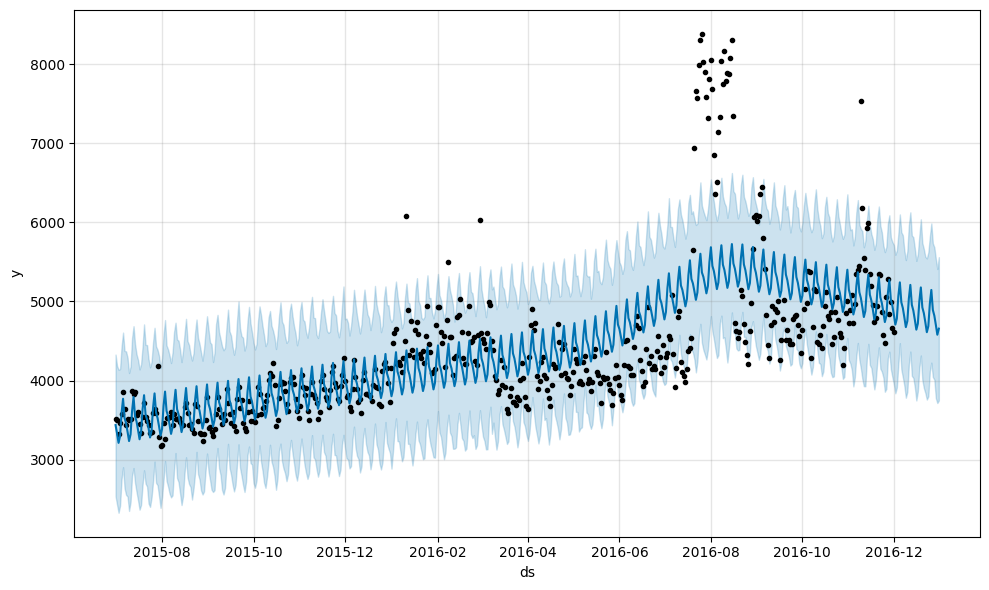

In [109]:
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.fit(TS_eng_prophet[['ds', 'y']][:-30])

# Create a dataframe for future dates
future = prophet_model.make_future_dataframe(periods=30)  # Forecast for the next 30 days

# Make predictions
prophet_forecast = prophet_model.predict(future)

# Plot the forecast
fig1 = prophet_model.plot(prophet_forecast)
fig1.show()

# Extract actual values for the last 30 days
y_true = TS_eng_prophet[-30:]['y'].values

# Extract forecasted values for those 30 days
y_pred = prophet_forecast[-30:]['yhat'].values

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape:.2f}%")

##### Let's create a prophet model using exogenous variable:

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc27s46t5/atmsmhji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc27s46t5/gbnx23pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82862', 'data', 'file=/tmp/tmpc27s46t5/atmsmhji.json', 'init=/tmp/tmpc27s46t5/gbnx23pi.json', 'output', 'file=/tmp/tmpc27s46t5/prophet_modelqss9gco2/prophet_model-20240618130136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:01:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:01:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 6.01%


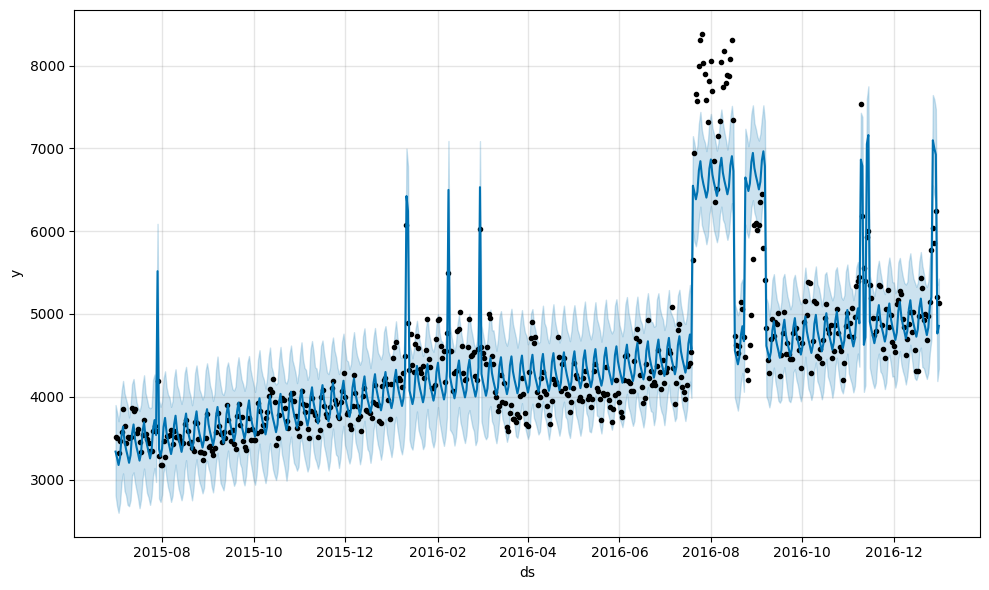

In [116]:
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.add_regressor('exog')
prophet_model.fit(TS_eng_prophet)
#future2 = prophet2.make_future_dataframe(periods=30, freq= 'D')
prophet_forecast = prophet_model.predict(TS_eng_prophet)
fig = prophet_model.plot(prophet_forecast)
fig.show()

# Extracting actual values
y_true = TS_eng_prophet['y'].values

# Extracting forecasted values
y_pred = prophet_forecast['yhat'].values

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape:.2f}%")

- MAPE without exog: 6.08%
- MAPE with exo:     6.01%

**So, use of exogenous variable has improved the performance of the model.**

## Recommendations & Questionnaire:

  - English has highest number of page visits followed by Japanese, so the add preference should be given in the same order.
  - More than 12% of web page's language is not recorded. With better recorded data, performance of the model can be improved considerably since 12% of it missing currently.

**What does the decomposition of series do?**
    
Decomposing a time series involves breaking it down into its key components:
    
- Trend: This represents the overall direction in which the data is moving over a long period. It shows whether the values are generally rising, falling, or remaining stable.

- Seasonality: These are the regular patterns or cycles that repeat at consistent intervals, such as daily, monthly, or yearly. For instance, sweater sales might be higher in the winter.

- Residual (or Noise): This is what’s left after removing the trend and seasonality from the data. It includes random variations and irregularities that aren't explained by the other components.

**What level of differencing gave you a stationary series?**

- In this case study, performing a single differencing step resulted in a stationary time series.

**Difference between arima, sarima & sarimax.**

ARIMA (AutoRegressive Integrated Moving Average):

- ARIMA (AutoRegressive Integrated Moving Average) is a statistical model used for time series data. It combines autoregression (using past values to predict future ones) and moving averages (using past prediction errors to forecast future values). 
- ARIMA models are represented as ARIMA(p, d, q), where p indicates the number of autoregressive terms, d is the number of differences needed to make the series stationary, and q denotes the number of lagged forecast errors in the model.
- ARIMA is great for non-seasonal data that becomes stationary after differencing.

SARIMA (Seasonal ARIMA):

- SARIMA takes ARIMA and adds seasonal components to it.
- SARIMA models are represented as SARIMA(p, d, q)(P, D, Q, S). Here, p, d, and q correspond to the same parameters in ARIMA models. Additionally, P indicates the seasonal autoregression order, D is the seasonal differencing order, Q represents the seasonal moving average order, and S denotes the number of periods in a season.
- SARIMA is perfect for data with clear seasonal patterns, capturing both regular and seasonal changes.

SARIMAX (Seasonal ARIMA with eXogenous regressors):

- SARIMAX includes everything in SARIMA and also lets you add external variables that might influence your data.
- Adds the ability to include external variables, making it ideal for more complex data influenced by other factors.
- A SARIMAX model is denoted by:

     **SARIMAX(𝑝,𝑑,𝑞)(𝑃,𝐷,𝑄,𝑆)X** 

  X represents the number of exogenous variables included in the model.

**Compare the number of views in different languages**

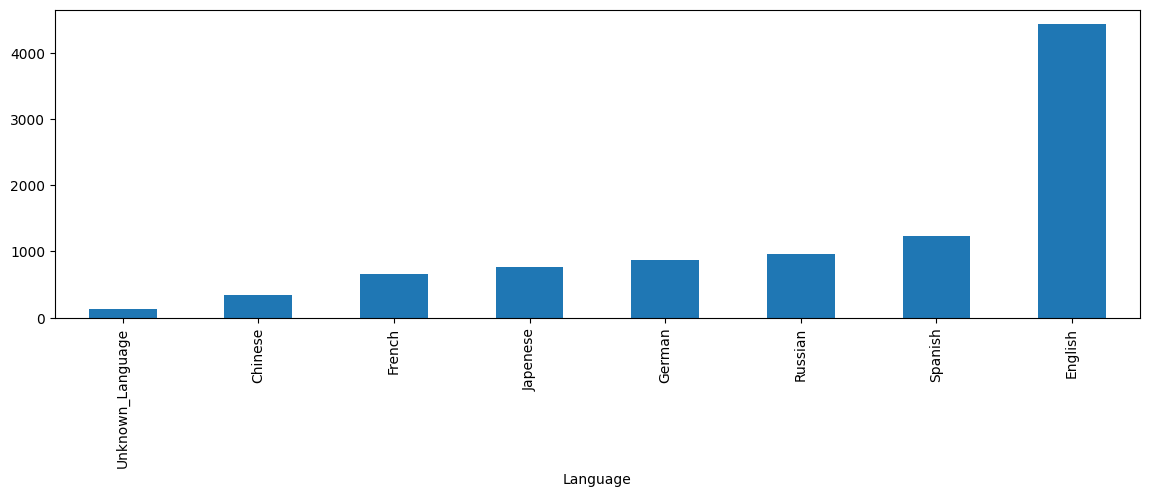

In [193]:
means_data.mean().sort_values().plot(kind = 'bar')
plt.show()

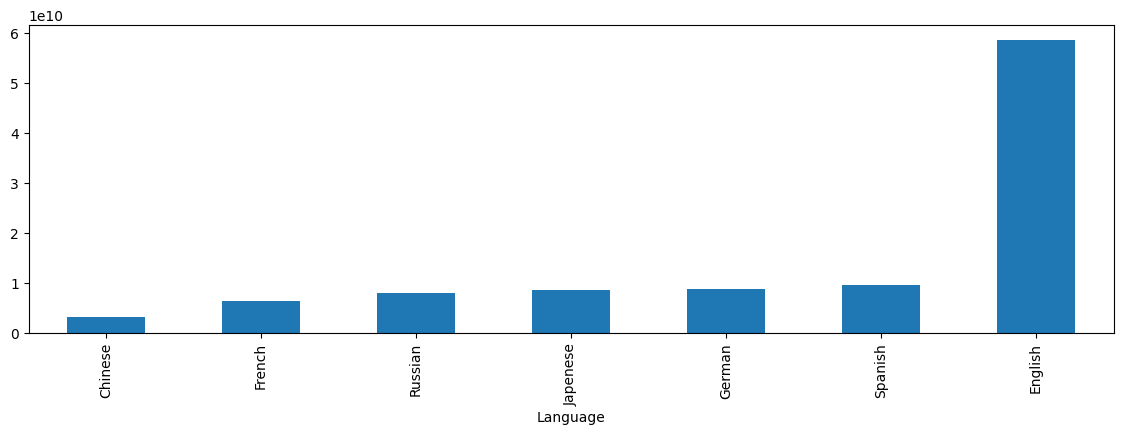

In [195]:
total = data.groupby('Language').sum().T.drop("Unknown_Language",axis = 1)

total.sum().sort_values().plot(kind = 'bar')
plt.show()

- Total number of visits to english pages is almost 6 times the next best language group.
- Where as the average visits is close to 4 times that of the next best language group.

**What other methods other than grid search would be suitable to get the model for all languages?**

When determining the values of p, q, and d from the ACF and PACF plots of a time series, follow these steps:

- Check the stationarity of the time series using an augmented Dickey-Fuller test.
- If the time series is stationary, proceed to fit an ARMA model. If non-stationary, determine the appropriate differencing order, d.
- Once stationarity is achieved, analyze the autocorrelation and partial autocorrelation plots of the data.
- Identify the parameter p by examining the cutoff in the partial autocorrelation plot (PACF).
- Determine the parameter q by examining the cutoff in the autocorrelation plot (ACF).